Sentiment Analysis of Movie Reviews: Comparing Traditional and Transfer Learning Approaches

Author: Ananyaa Tanwar

Course: IS 517 Fall 2025

# PHASE 1: Environment and Setup Imports

In [ ]:
!pip install gensim

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score)

# Deep Learning and NLP
import tensorflow as tf
import tensorflow_datasets as tfds

# Word embeddings
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score)

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
import time

In [ ]:
# downloading NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [ ]:
# to check tensorflow and gensim versions

print(f"✓ Random seed set to {RANDOM_STATE}")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Gensim version: {gensim.__version__}")


✓ Random seed set to 42
✓ TensorFlow version: 2.19.0
✓ Gensim version: 4.4.0


# PHASE 2: DATA LOADING & INITIAL EXPLORATION

In [ ]:
# Loading IMDB dataset from TensorFlow Datasets
# Loading train and test splits
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=['train', 'test'],
    as_supervised=True,
    batch_size=-1
)

In [ ]:
# Converting data to numpy arrays
train_reviews, train_labels = tfds.as_numpy(train_data)
test_reviews, test_labels = tfds.as_numpy(test_data)

In [ ]:
# Decoding bytes to strings
train_reviews = [review.decode('utf-8') for review in train_reviews]
test_reviews = [review.decode('utf-8') for review in test_reviews]

In [ ]:
print(f"Training samples: {len(train_reviews):,}")
print(f"Testing samples: {len(test_reviews):,}")
print(f"Total samples: {len(train_reviews) + len(test_reviews):,}")

Training samples: 25,000
Testing samples: 25,000
Total samples: 50,000


In [ ]:
# Creating pandas DataFrames for easier manipulation
train_df = pd.DataFrame({
    'review': train_reviews,
    'sentiment': train_labels
})

test_df = pd.DataFrame({
    'review': test_reviews,
    'sentiment': test_labels
})

In [ ]:
# Combining training and testing df for comprehensive EDA only
full_df = pd.concat([
    train_df.assign(split='train'),
    test_df.assign(split='test')
], ignore_index=True)


In [ ]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Combined shape: {full_df.shape}")

Train shape: (25000, 2)
Test shape: (25000, 2)
Combined shape: (50000, 3)


In [ ]:
# Display dataset structure
print("Dataset structure:")
print("First few rows:")
print(full_df.head())
print("\n\n\nDataset info:")
print(full_df.info())

Dataset structure:
First few rows:
                                                                                                review  \
0  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironsi...   
1  I have been known to fall asleep during films, but this is usually due to a combination of thing...   
2  Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter B...   
3  This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead wi...   
4  As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous...   

   sentiment  split  
0          0  train  
1          0  train  
2          0  train  
3          1  train  
4          1  train  



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  

In [ ]:
# Checking for any missing values
missing_values = full_df.isnull().sum()
print(missing_values)
if missing_values.sum() == 0:
    print("No missing values found")

review       0
sentiment    0
split        0
dtype: int64
No missing values found


In [ ]:
# Displaying sample reviews (positive and negative)
print("Sample reviews:")
print("\nPOSITIVE REVIEW (label=1)")
positive_sample = full_df[full_df['sentiment'] == 1].iloc[0]['review']
print(positive_sample[:500] + "..." if len(positive_sample) > 500 else positive_sample)

print("\nNEGATIVE REVIEW (label=0)")
negative_sample = full_df[full_df['sentiment'] == 0].iloc[0]['review']
print(negative_sample[:500] + "..." if len(negative_sample) > 500 else negative_sample)

Sample reviews:

POSITIVE REVIEW (label=1)
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.

NEGATIVE REVIEW (label=0)
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love

In [ ]:
# Calculating basic stats about data (review length and word count)
print("Basic statistics:")
full_df['review_length'] = full_df['review'].apply(len)
full_df['word_count'] = full_df['review'].apply(lambda x: len(x.split()))

stats = full_df[['review_length', 'word_count']].describe()
print("\nReview length and word count statistics:")
print(stats)

Basic statistics:

Review length and word count statistics:
       review_length    word_count
count   50000.000000  50000.000000
mean     1309.431020    231.156940
std       989.728014    171.343997
min        32.000000      4.000000
25%       699.000000    126.000000
50%       970.000000    173.000000
75%      1590.250000    280.000000
max     13704.000000   2470.000000


# PHASE 3: EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
# Creating a figure for all eda visualizations
fig = plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

Analyzing class distribution
Class distribution:
Negative reviews: 25,000 (50.0%)
Positive reviews: 25,000 (50.0%)
Dataset is balanced


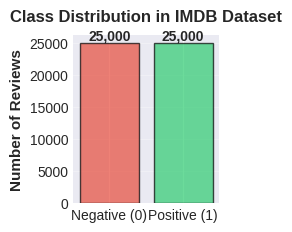

In [ ]:
# 1: Class Distribution of review
print("Analyzing class distribution")
ax1 = plt.subplot(2, 3, 1)
class_counts = full_df['sentiment'].value_counts().sort_index()
sentiment_labels = ['Negative (0)', 'Positive (1)']
colors = ['#e74c3c', '#2ecc71']

bars = ax1.bar(sentiment_labels, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Reviews', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution in IMDB Dataset', fontsize=12, fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold')

print(f"Class distribution:")
print(f"Negative reviews: {class_counts[0]:,} ({class_counts[0]/len(full_df)*100:.1f}%)")
print(f"Positive reviews: {class_counts[1]:,} ({class_counts[1]/len(full_df)*100:.1f}%)")
print(f"Dataset is {'balanced' if abs(class_counts[0] - class_counts[1]) < 1000 else 'imbalanced'}")


Analyzing review length distribution...


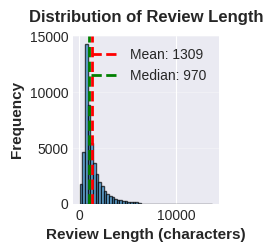

In [ ]:
# 2: Review Length Distribution
print("Analyzing review length distribution...")
ax2 = plt.subplot(2, 3, 2)
ax2.hist(full_df['review_length'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax2.axvline(full_df['review_length'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {full_df["review_length"].mean():.0f}')
ax2.axvline(full_df['review_length'].median(), color='green', linestyle='--',
            linewidth=2, label=f'Median: {full_df["review_length"].median():.0f}')
ax2.set_xlabel('Review Length (characters)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Review Length', fontsize=12, fontweight='bold', pad=10)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)


[3/5] Analyzing word count distribution...


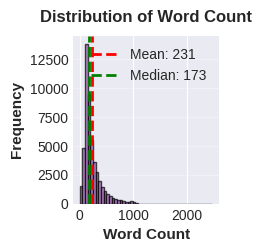

In [ ]:
# 3: Word Count Distribution
print("\n[3/5] Analyzing word count distribution...")
ax3 = plt.subplot(2, 3, 3)
ax3.hist(full_df['word_count'], bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.axvline(full_df['word_count'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {full_df["word_count"].mean():.0f}')
ax3.axvline(full_df['word_count'].median(), color='green', linestyle='--',
            linewidth=2, label=f'Median: {full_df["word_count"].median():.0f}')
ax3.set_xlabel('Word Count', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Word Count', fontsize=12, fontweight='bold', pad=10)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

Comparing review length by sentiment...
Average review length:
Negative reviews: 1294 characters
Positive reviews: 1325 characters


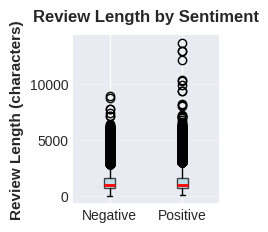

In [ ]:
# 4: Review Length by Sentiment
print("Comparing review length by sentiment...")
ax4 = plt.subplot(2, 3, 4)
positive_lengths = full_df[full_df['sentiment'] == 1]['review_length']
negative_lengths = full_df[full_df['sentiment'] == 0]['review_length']

box_data = [negative_lengths, positive_lengths]
bp = ax4.boxplot(box_data, labels=['Negative', 'Positive'], patch_artist=True,
                 medianprops=dict(color='red', linewidth=2),
                 boxprops=dict(facecolor='lightblue', alpha=0.7))
ax4.set_ylabel('Review Length (characters)', fontsize=11, fontweight='bold')
ax4.set_title('Review Length by Sentiment', fontsize=12, fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3)

print(f"Average review length:")
print(f"Negative reviews: {negative_lengths.mean():.0f} characters")
print(f"Positive reviews: {positive_lengths.mean():.0f} characters")

Comparing word count by sentiment...
Average word count:
Negative reviews: 229 words
Positive reviews: 233 words


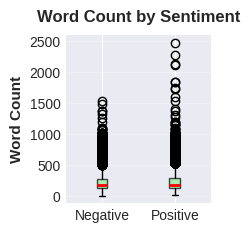

In [ ]:
# 5: Word Count by Sentiment
print("Comparing word count by sentiment...")
ax5 = plt.subplot(2, 3, 5)
positive_words = full_df[full_df['sentiment'] == 1]['word_count']
negative_words = full_df[full_df['sentiment'] == 0]['word_count']

box_data = [negative_words, positive_words]
bp = ax5.boxplot(box_data, labels=['Negative', 'Positive'], patch_artist=True,
                 medianprops=dict(color='red', linewidth=2),
                 boxprops=dict(facecolor='lightgreen', alpha=0.7))
ax5.set_ylabel('Word Count', fontsize=11, fontweight='bold')
ax5.set_title('Word Count by Sentiment', fontsize=12, fontweight='bold', pad=10)
ax5.grid(axis='y', alpha=0.3)

print(f"Average word count:")
print(f"Negative reviews: {negative_words.mean():.0f} words")
print(f"Positive reviews: {positive_words.mean():.0f} words")

Identifying most common words...
Top 10 most common words:
   1. 'the': 638,861 occurrences
   2. 'a': 316,615 occurrences
   3. 'and': 313,637 occurrences
   4. 'of': 286,661 occurrences
   5. 'to': 264,573 occurrences
   6. 'is': 204,876 occurrences
   7. 'in': 179,807 occurrences
   8. 'i': 141,587 occurrences
   9. 'this': 138,483 occurrences
  10. 'that': 130,140 occurrences

Visualizations saved as 'eda_visualizations.png'


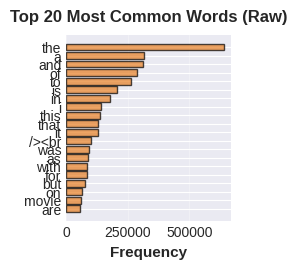

In [ ]:
# 6: Most Common Words (simple frequency analysis)
print("Identifying most common words...")
ax6 = plt.subplot(2, 3, 6)

# Simple word frequency (will improve in preprocessing phase)
all_words = ' '.join(full_df['review'].str.lower()).split()
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)
words, counts = zip(*most_common)

ax6.barh(range(len(words)), counts, color='#e67e22', alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(words)))
ax6.set_yticklabels(words)
ax6.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Top 20 Most Common Words (Raw)', fontsize=12, fontweight='bold', pad=10)
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

print(f"Top 10 most common words:")
for i, (word, count) in enumerate(most_common[:10], 1):
    print(f"  {i:2d}. '{word}': {count:,} occurrences")

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\nVisualizations saved as 'eda_visualizations.png'")
plt.show()

In [ ]:
# Summary Statistics Table

print("SUMMARY STATISTICS")

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Reviews',
        'Training Reviews',
        'Testing Reviews',
        'Positive Reviews',
        'Negative Reviews',
        'Avg Review Length (chars)',
        'Avg Word Count',
        'Min Word Count',
        'Max Word Count'
    ],
    'Value': [
        f"{len(full_df):,}",
        f"{len(train_df):,}",
        f"{len(test_df):,}",
        f"{class_counts[1]:,}",
        f"{class_counts[0]:,}",
        f"{full_df['review_length'].mean():.0f}",
        f"{full_df['word_count'].mean():.0f}",
        f"{full_df['word_count'].min()}",
        f"{full_df['word_count'].max():,}"
    ]
})

print(summary_stats.to_string(index=False))

SUMMARY STATISTICS
                   Metric  Value
            Total Reviews 50,000
         Training Reviews 25,000
          Testing Reviews 25,000
         Positive Reviews 25,000
         Negative Reviews 25,000
Avg Review Length (chars)   1309
           Avg Word Count    231
           Min Word Count      4
           Max Word Count  2,470


# PHASE 4: TEXT PREPROCESSING


In [ ]:
# Define contractions dictionary for expansion
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot",
    "can't've": "cannot have", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "might've": "might have",
    "mightn't": "might not", "must've": "must have", "mustn't": "must not",
    "needn't": "need not", "o'clock": "of the clock", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "that'd": "that would",
    "that's": "that is", "there'd": "there would", "there's": "there is",
    "they'd": "they would", "they'll": "they will", "they're": "they are",
    "they've": "they have", "wasn't": "was not", "we'd": "we would",
    "we'll": "we will", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is",
    "where'd": "where did", "where's": "where is", "who'll": "who will",
    "who's": "who is", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}

In [ ]:
# Creating regex pattern for contractions
contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                  flags=re.IGNORECASE|re.DOTALL)

## Helper Functions to transform text

In [ ]:
def expand_contractions(text, contractions_dict=contractions_dict):
    """Expand contractions in text"""
    def replace(match):
        return contractions_dict[match.group(0).lower()]
    return contractions_pattern.sub(replace, text)

In [ ]:
def clean_text(text):
    """
    Clean and normalize text:
    1. Convert to lowercase
    2. Expand contractions
    3. Remove HTML tags
    4. Remove URLs
    5. Remove special characters (keep only letters and spaces)
    6. Remove extra whitespace
    """
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', ' ', text)

    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
def tokenize_text(text):
    """Tokenize text into words"""
    return word_tokenize(text)

In [ ]:
def remove_stopwords(tokens):
    """Remove common English stopwords"""
    stop_words = set(stopwords.words('english'))
    # Keep negation words as they're important for sentiment
    negation_words = {'no', 'not', 'nor', 'neither', 'never', 'none', 'nobody', 'nothing', 'nowhere'}
    stop_words = stop_words - negation_words
    return [word for word in tokens if word not in stop_words]

In [ ]:
def preprocess_pipeline(text, remove_stops=False):
    """
    Complete preprocessing pipeline
    Args:
        text: Input text string
        remove_stops: Whether to remove stopwords (default False)
    Returns:
        Preprocessed text string
    """
    # Clean text
    cleaned = clean_text(text)

    # Tokenize
    tokens = tokenize_text(cleaned)

    # Optionally remove stopwords
    if remove_stops:
        tokens = remove_stopwords(tokens)

    # Join back into string
    return ' '.join(tokens)

## Text Processing

In [ ]:
# Test preprocessing on sample reviews
print("Testing preprocessing pipeline")
print("\nORIGINAL REVIEW")
sample_review = train_df['review'].iloc[0][:300]
print(sample_review)

print("\nAFTER PREPROCESSING (with stopwords)")
preprocessed_with_stops = preprocess_pipeline(train_df['review'].iloc[0], remove_stops=False)
print(preprocessed_with_stops[:300])

print("\nAFTER PREPROCESSING (without stopwords)")
preprocessed_without_stops = preprocess_pipeline(train_df['review'].iloc[0], remove_stops=True)
print(preprocessed_without_stops[:300])

Testing preprocessing pipeline

ORIGINAL REVIEW
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda pi

AFTER PREPROCESSING (with stopwords)
this was an absolutely terrible movie do not be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie s ridiculous storyline this movie is an early nineties us propaganda piece 

AFTER PREPROCESSING (without stopwords)
absolutely terrible movie not lured christopher walken michael ironside great actors must simply worst role history even great acting could not redeem movie ridiculous storyline movie early nineties us propaganda piece pathetic scenes columbian rebels making cases revolu

In [ ]:
# Applying preprocessing to entire dataset
print("Applying preprocessing to training data")
start_time = time.time()

# Making a version without stopword removal (better for TF-IDF)
train_df['cleaned_text'] = train_df['review'].apply(lambda x: preprocess_pipeline(x, remove_stops=False))
print(f"Training data preprocessed in {time.time() - start_time:.2f} seconds")

print("\nApplying preprocessing to test data")
start_time = time.time()
test_df['cleaned_text'] = test_df['review'].apply(lambda x: preprocess_pipeline(x, remove_stops=False))
print(f"Test data preprocessed in {time.time() - start_time:.2f} seconds")

Applying preprocessing to training data
Training data preprocessed in 64.05 seconds

Applying preprocessing to test data
Test data preprocessed in 57.80 seconds


In [ ]:
# Calculating stats on cleaned text
print("Calculating Preprocessing Statistics")
train_df['cleaned_length'] = train_df['cleaned_text'].apply(len)
train_df['cleaned_word_count'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

reduction_chars = ((train_df['review'].apply(len).mean() - train_df['cleaned_length'].mean()) /
                   train_df['review'].apply(len).mean() * 100)
reduction_words = ((train_df['review'].apply(lambda x: len(x.split())).mean() -
                   train_df['cleaned_word_count'].mean()) /
                   train_df['review'].apply(lambda x: len(x.split())).mean() * 100)

print(f"\nPreprocessing impact:")
print(f"Average character reduction: {reduction_chars:.1f}%")
print(f"Average word count reduction: {reduction_words:.1f}%")
print(f"Original avg word count: {train_df['review'].apply(lambda x: len(x.split())).mean():.0f}")
print(f"Cleaned avg word count: {train_df['cleaned_word_count'].mean():.0f}")


Calculating Preprocessing Statistics

Preprocessing impact:
Average character reduction: 4.4%
Average word count reduction: -1.3%
Original avg word count: 234
Cleaned avg word count: 237


In [ ]:
# Saving preprocessed data
print("Saving preprocessed data")
train_df.to_pickle('train_preprocessed.pkl')
test_df.to_pickle('test_preprocessed.pkl')
print("Preprocessed data saved to pickle files")

Saving preprocessed data
Preprocessed data saved to pickle files


# PHASE 5: TRAIN-TEST SPLIT (Already split, just verify)

In [ ]:
print("Verifying existing train-test split")
print(f"Training set size: {len(train_df):,} ({len(train_df)/(len(train_df)+len(test_df))*100:.1f}%)")
print(f"Test set size: {len(test_df):,} ({len(test_df)/(len(train_df)+len(test_df))*100:.1f}%)")

Verifying existing train-test split
Training set size: 25,000 (50.0%)
Test set size: 25,000 (50.0%)


In [ ]:
print("Checking class balance in splits:")
train_positive = (train_df['sentiment'] == 1).sum()
train_negative = (train_df['sentiment'] == 0).sum()
test_positive = (test_df['sentiment'] == 1).sum()
test_negative = (test_df['sentiment'] == 0).sum()

print("\nTraining set:")
print(f"Positive: {train_positive:,} ({train_positive/len(train_df)*100:.1f}%)")
print(f"Negative: {train_negative:,} ({train_negative/len(train_df)*100:.1f}%)")

print("\nTest set:")
print(f"Positive: {test_positive:,} ({test_positive/len(test_df)*100:.1f}%)")
print(f"Negative: {test_negative:,} ({test_negative/len(test_df)*100:.1f}%)")

print("Split Validation:")
if abs(train_positive - train_negative) < 100 and abs(test_positive - test_negative) < 100:
    print("Both splits are well-balanced")
else:
    print("Warning: Splits show class imbalance")

Checking class balance in splits:

Training set:
Positive: 12,500 (50.0%)
Negative: 12,500 (50.0%)

Test set:
Positive: 12,500 (50.0%)
Negative: 12,500 (50.0%)
Split Validation:
Both splits are well-balanced


In [ ]:
# Extracting features and labels
X_train = train_df['cleaned_text'].values
y_train = train_df['sentiment'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['sentiment'].values

print(f"\nFeature matrices created:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Feature matrices created:
X_train shape: (25000,)
y_train shape: (25000,)
X_test shape: (25000,)
y_test shape: (25000,)


# PHASE 6: METHOD 1: TF-IDF FEATURE EXTRACTION

In [ ]:
print("Initializing TF-IDF Vectorizer")

# Initializing TF-IDF with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,      # limit to top 10,000 features
    min_df=5,                # words must appear in at least 5 documents
    max_df=0.8,              # ignore words appearing in >80% of documents
    ngram_range=(1, 2),      # use unigrams and bigrams
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{2,}\b',  # words with 2+ letters
    sublinear_tf=True        # apply sublinear tf scaling
)

print("TF-IDF Vectorizer initialized with parameters:")
print(f"max_features: 10,000")
print(f"min_df: 5 (word must appear in ≥5 documents)")
print(f"max_df: 0.8 (ignore words in >80% of documents)")
print(f"ngram_range: (1, 2) - unigrams and bigrams")
print(f"sublinear_tf: True")

Initializing TF-IDF Vectorizer
TF-IDF Vectorizer initialized with parameters:
max_features: 10,000
min_df: 5 (word must appear in ≥5 documents)
max_df: 0.8 (ignore words in >80% of documents)
ngram_range: (1, 2) - unigrams and bigrams
sublinear_tf: True


In [ ]:
print("Fitting TF-IDF on training data")
start_time = time.time()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
fit_time = time.time() - start_time
print(f"TF-IDF fitted in {fit_time:.2f} seconds")

Fitting TF-IDF on training data
TF-IDF fitted in 22.53 seconds


In [ ]:
print("Transforming test data...")
start_time = time.time()
tfidf_test = tfidf_vectorizer.transform(X_test)
transform_time = time.time() - start_time
print(f"Test data transformed in {transform_time:.2f} seconds")

Transforming test data...
Test data transformed in 14.28 seconds


In [ ]:
print("TF-IDF matrix statistics:")
print(f"Training matrix shape: {tfidf_train.shape}")
print(f"Test matrix shape: {tfidf_test.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out()):,}")
print(f"Matrix sparsity: {(1 - tfidf_train.nnz / (tfidf_train.shape[0] * tfidf_train.shape[1])) * 100:.2f}%")
print(f"Memory usage (train): {tfidf_train.data.nbytes / (1024**2):.2f} MB")
print(f"Memory usage (test): {tfidf_test.data.nbytes / (1024**2):.2f} MB")

TF-IDF matrix statistics:
Training matrix shape: (25000, 10000)
Test matrix shape: (25000, 10000)
Number of features: 10,000
Matrix sparsity: 98.20%
Memory usage (train): 34.27 MB
Memory usage (test): 33.53 MB


In [ ]:
print("Analyzing top TF-IDF features")

# Getting feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculating mean TF-IDF score for each feature across all documents
mean_tfidf = np.array(tfidf_train.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[-20:][::-1]

print("\nTop 20 features by mean TF-IDF score:")
for i, idx in enumerate(top_indices, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': {mean_tfidf[idx]:.4f}")

Analyzing top TF-IDF features

Top 20 features by mean TF-IDF score:
   1. 'movie': 0.0284
   2. 'was': 0.0279
   3. 'as': 0.0256
   4. 'film': 0.0252
   5. 'for': 0.0251
   6. 'but': 0.0249
   7. 'with': 0.0247
   8. 'you': 0.0238
   9. 'of the': 0.0237
  10. 'have': 0.0227
  11. 'are': 0.0224
  12. 'on': 0.0222
  13. 'it is': 0.0209
  14. 'one': 0.0204
  15. 'be': 0.0202
  16. 'he': 0.0196
  17. 'his': 0.0196
  18. 'all': 0.0193
  19. 'in the': 0.0190
  20. 'at': 0.0188


In [ ]:
# Finding discriminative features
print("Analyzing discriminative features...")

# Calculate mean TF-IDF for positive and negative reviews
positive_mask = y_train == 1
negative_mask = y_train == 0

positive_mean = np.array(tfidf_train[positive_mask].mean(axis=0)).flatten()
negative_mean = np.array(tfidf_train[negative_mask].mean(axis=0)).flatten()

# Calculate the DIFFERENCE (discriminative power)
positive_discriminative = positive_mean - negative_mean
negative_discriminative = negative_mean - positive_mean

# Top features that appear MORE in positive reviews
top_positive_discriminative = positive_discriminative.argsort()[-20:][::-1]
print("\nTop 20 features MORE indicative of POSITIVE reviews:")
for i, idx in enumerate(top_positive_discriminative, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': +{positive_discriminative[idx]:.4f} "
          f"(pos: {positive_mean[idx]:.4f}, neg: {negative_mean[idx]:.4f})")

# Top features that appear MORE in negative reviews
top_negative_discriminative = negative_discriminative.argsort()[-20:][::-1]
print("\nTop 20 features MORE indicative of NEGATIVE reviews:")
for i, idx in enumerate(top_negative_discriminative, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': +{negative_discriminative[idx]:.4f} "
          f"(neg: {negative_mean[idx]:.4f}, pos: {positive_mean[idx]:.4f})")

Analyzing discriminative features...

Top 20 features MORE indicative of POSITIVE reviews:
   1. 'great': +0.0101 (pos: 0.0173, neg: 0.0072)
   2. 'best': +0.0067 (pos: 0.0130, neg: 0.0063)
   3. 'love': +0.0063 (pos: 0.0126, neg: 0.0063)
   4. 'excellent': +0.0062 (pos: 0.0079, neg: 0.0017)
   5. 'the best': +0.0058 (pos: 0.0095, neg: 0.0037)
   6. 'wonderful': +0.0055 (pos: 0.0068, neg: 0.0014)
   7. 'very': +0.0050 (pos: 0.0176, neg: 0.0126)
   8. 'well': +0.0050 (pos: 0.0151, neg: 0.0101)
   9. 'his': +0.0046 (pos: 0.0219, neg: 0.0173)
  10. 'also': +0.0046 (pos: 0.0133, neg: 0.0088)
  11. 'is great': +0.0042 (pos: 0.0055, neg: 0.0012)
  12. 'beautiful': +0.0042 (pos: 0.0067, neg: 0.0025)
  13. 'perfect': +0.0041 (pos: 0.0057, neg: 0.0015)
  14. 'life': +0.0041 (pos: 0.0113, neg: 0.0072)
  15. 'one of': +0.0040 (pos: 0.0130, neg: 0.0089)
  16. 'amazing': +0.0039 (pos: 0.0052, neg: 0.0013)
  17. 'as': +0.0039 (pos: 0.0276, neg: 0.0237)
  18. 'loved': +0.0039 (pos: 0.0056, neg: 0.001

In [ ]:
# # Create a professional visualization of discriminative features for your slide
# import matplotlib.pyplot as plt
# import numpy as np

# # Calculate discriminative features (from previous code)
# positive_mask = y_train == 1
# negative_mask = y_train == 0

# positive_mean = np.array(tfidf_train[positive_mask].mean(axis=0)).flatten()
# negative_mean = np.array(tfidf_train[negative_mask].mean(axis=0)).flatten()

# # Calculate the DIFFERENCE (discriminative power)
# positive_discriminative = positive_mean - negative_mean
# negative_discriminative = negative_mean - positive_mean

# # Get top 15 for each
# top_positive_discriminative = positive_discriminative.argsort()[-15:][::-1]
# top_negative_discriminative = negative_discriminative.argsort()[-15:][::-1]

# # Extract words and scores
# pos_words = [feature_names[idx] for idx in top_positive_discriminative]
# pos_scores = [positive_discriminative[idx] for idx in top_positive_discriminative]

# neg_words = [feature_names[idx] for idx in top_negative_discriminative]
# neg_scores = [negative_discriminative[idx] for idx in top_negative_discriminative]

# # Create side-by-side visualization
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# # Positive sentiment words
# bars1 = ax1.barh(range(len(pos_words)), pos_scores, color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
# ax1.set_yticks(range(len(pos_words)))
# ax1.set_yticklabels(pos_words, fontsize=12, fontweight='bold')
# ax1.set_xlabel('Discriminative Score\n(Higher = More Positive)', fontsize=13, fontweight='bold')
# ax1.set_title('Top 15 Words Indicating POSITIVE Sentiment', fontsize=14, fontweight='bold', pad=15, color='#27ae60')
# ax1.invert_yaxis()
# ax1.grid(axis='x', alpha=0.3, linestyle='--')

# # Add value labels
# for i, (bar, score) in enumerate(zip(bars1, pos_scores)):
#     ax1.text(score + 0.0003, i, f'{score:.4f}',
#              va='center', fontsize=10, fontweight='bold')

# # Negative sentiment words
# bars2 = ax2.barh(range(len(neg_words)), neg_scores, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
# ax2.set_yticks(range(len(neg_words)))
# ax2.set_yticklabels(neg_words, fontsize=12, fontweight='bold')
# ax2.set_xlabel('Discriminative Score\n(Higher = More Negative)', fontsize=13, fontweight='bold')
# ax2.set_title('Top 15 Words Indicating NEGATIVE Sentiment', fontsize=14, fontweight='bold', pad=15, color='#c0392b')
# ax2.invert_yaxis()
# ax2.grid(axis='x', alpha=0.3, linestyle='--')

# # Add value labels
# for i, (bar, score) in enumerate(zip(bars2, neg_scores)):
#     ax2.text(score + 0.0003, i, f'{score:.4f}',
#              va='center', fontsize=10, fontweight='bold')

# plt.tight_layout()
# plt.savefig('discriminative_features_for_slide.png', dpi=300, bbox_inches='tight', facecolor='white')
# print("✓ Visualization saved as 'discriminative_features_for_slide.png'")
# print("\nThis image is perfect for your presentation slide!")
# plt.show()

# # Also create a simple text table for backup
# print("\n" + "=" * 80)
# print("DISCRIMINATIVE FEATURES - TEXT VERSION (for slide notes)")
# print("=" * 80)

# print("\n📊 TOP POSITIVE SENTIMENT WORDS:")
# print("-" * 50)
# for i, (word, score) in enumerate(zip(pos_words[:10], pos_scores[:10]), 1):
#     print(f"{i:2d}. {word:20s} (+{score:.4f})")

# print("\n📊 TOP NEGATIVE SENTIMENT WORDS:")
# print("-" * 50)
# for i, (word, score) in enumerate(zip(neg_words[:10], neg_scores[:10]), 1):
#     print(f"{i:2d}. {word:20s} (+{score:.4f})")

In [ ]:
# Separating top features for positive and negative reviews
print("\nTop 15 features for POSITIVE reviews:")
positive_mask = y_train == 1
positive_mean = np.array(tfidf_train[positive_mask].mean(axis=0)).flatten()
top_positive = positive_mean.argsort()[-15:][::-1]
for i, idx in enumerate(top_positive, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': {positive_mean[idx]:.4f}")

print("\nTop 15 features for NEGATIVE reviews:")
negative_mask = y_train == 0
negative_mean = np.array(tfidf_train[negative_mask].mean(axis=0)).flatten()
top_negative = negative_mean.argsort()[-15:][::-1]
for i, idx in enumerate(top_negative, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': {negative_mean[idx]:.4f}")


Top 15 features for POSITIVE reviews:
   1. 'as': 0.0276
   2. 'film': 0.0261
   3. 'movie': 0.0257
   4. 'with': 0.0255
   5. 'was': 0.0254
   6. 'for': 0.0251
   7. 'of the': 0.0248
   8. 'but': 0.0239
   9. 'you': 0.0234
  10. 'are': 0.0221
  11. 'it is': 0.0221
  12. 'his': 0.0219
  13. 'on': 0.0217
  14. 'have': 0.0209
  15. 'one': 0.0206

Top 15 features for NEGATIVE reviews:
   1. 'movie': 0.0311
   2. 'was': 0.0304
   3. 'but': 0.0258
   4. 'for': 0.0251
   5. 'have': 0.0244
   6. 'film': 0.0244
   7. 'you': 0.0242
   8. 'with': 0.0240
   9. 'as': 0.0237
  10. 'on': 0.0227
  11. 'are': 0.0227
  12. 'of the': 0.0225
  13. 'be': 0.0217
  14. 'they': 0.0204
  15. 'one': 0.0202


In [ ]:
# Saving TF-IDF vectorizer and matrices
print("Saving TF-IDF vectorizer and matrices...")
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('tfidf_matrices.pkl', 'wb') as f:
    pickle.dump({
        'train': tfidf_train,
        'test': tfidf_test,
        'y_train': y_train,
        'y_test': y_test
    }, f)

print("TF-IDF vectorizer and matrices saved")

Saving TF-IDF vectorizer and matrices...
TF-IDF vectorizer and matrices saved


TF-IDF feature visualization saved as 'tfidf_top_features.png'


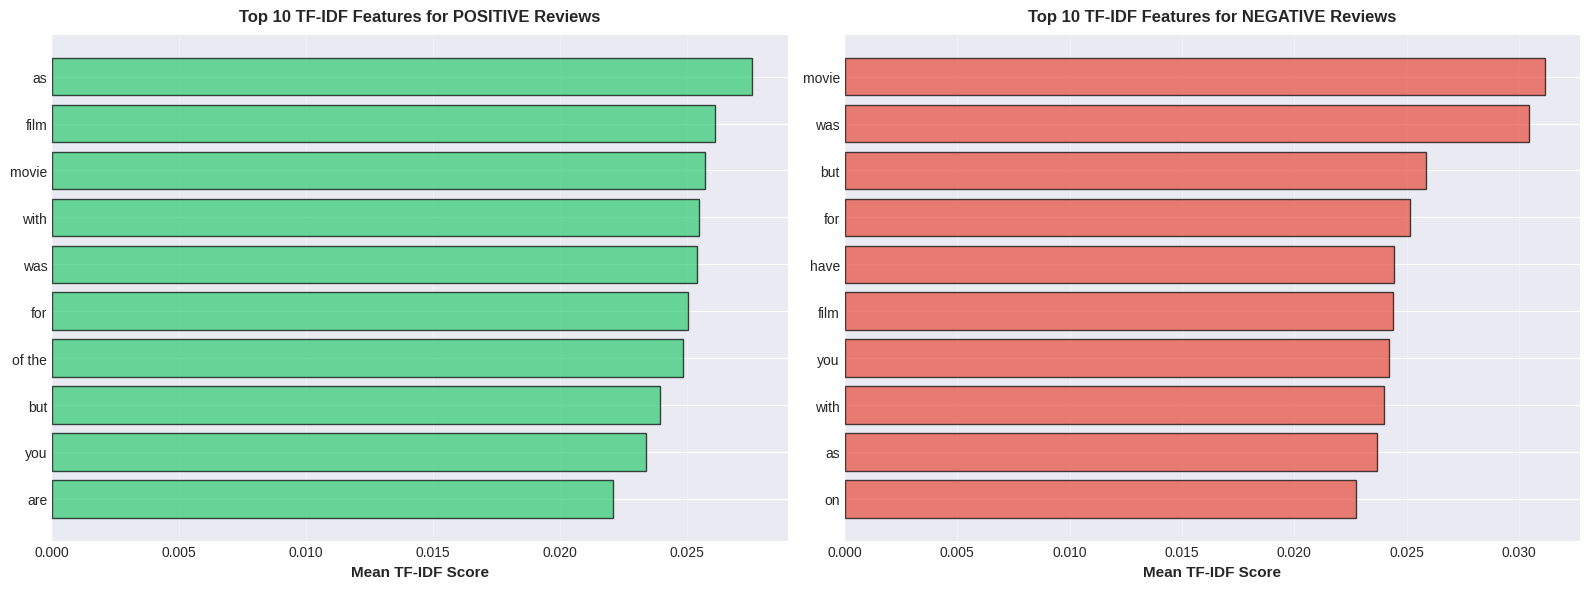

In [ ]:
# Create visualization of top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top positive features
top_pos_words = [feature_names[i] for i in top_positive[:10]]
top_pos_scores = [positive_mean[i] for i in top_positive[:10]]
ax1.barh(range(len(top_pos_words)), top_pos_scores, color='#2ecc71', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(top_pos_words)))
ax1.set_yticklabels(top_pos_words)
ax1.set_xlabel('Mean TF-IDF Score', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 TF-IDF Features for POSITIVE Reviews', fontsize=12, fontweight='bold', pad=10)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Top negative features
top_neg_words = [feature_names[i] for i in top_negative[:10]]
top_neg_scores = [negative_mean[i] for i in top_negative[:10]]
ax2.barh(range(len(top_neg_words)), top_neg_scores, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(top_neg_words)))
ax2.set_yticklabels(top_neg_words)
ax2.set_xlabel('Mean TF-IDF Score', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 TF-IDF Features for NEGATIVE Reviews', fontsize=12, fontweight='bold', pad=10)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('tfidf_top_features.png', dpi=300, bbox_inches='tight')
print("TF-IDF feature visualization saved as 'tfidf_top_features.png'")
plt.show()

# PHASE 7: TF-IDF MODEL TRAINING (Methods: Logistic Regression and Random Forest)

In [ ]:
# Loading preprocessed data and TF-IDF matrices
print("Loading preprocessed TF-IDF matrices...")
with open('tfidf_matrices.pkl', 'rb') as f:
    data = pickle.load(f)
    tfidf_train = data['train']
    tfidf_test = data['test']
    y_train = data['y_train']
    y_test = data['y_test']

print(f"Data loaded successfully")
print(f"Training samples: {tfidf_train.shape[0]:,}")
print(f"Test samples: {tfidf_test.shape[0]:,}")
print(f"Features: {tfidf_train.shape[1]:,}")

Loading preprocessed TF-IDF matrices...
Data loaded successfully
Training samples: 25,000
Test samples: 25,000
Features: 10,000


## Model 1: Logistic Regression

In [ ]:
print("Initializing Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,                    # Regularization strength
    solver='liblinear',       # Good for small to medium datasets
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

print("Model initialized with parameters:")
print(f"max_iter: 1000")
print(f"C (inverse regularization): 1.0")
print(f"solver: liblinear")
print(f"random_state: 42")

Initializing Logistic Regression...
Model initialized with parameters:
max_iter: 1000
C (inverse regularization): 1.0
solver: liblinear
random_state: 42


In [ ]:
print("Training Logistic Regression on TF-IDF features...")
start_time = time.time()
lr_model.fit(tfidf_train, y_train)
lr_train_time = time.time() - start_time
print(f"Model trained successfully in {lr_train_time:.2f} seconds")

Training Logistic Regression on TF-IDF features...
Model trained successfully in 2.53 seconds


In [ ]:
print("Making predictions on training set...")
start_time = time.time()
lr_train_pred = lr_model.predict(tfidf_train)
lr_train_pred_time = time.time() - start_time

lr_train_accuracy = accuracy_score(y_train, lr_train_pred)
print(f"Training accuracy: {lr_train_accuracy*100:.2f}%")
print(f"(Prediction time: {lr_train_pred_time:.2f} seconds)")

Making predictions on training set...
Training accuracy: 93.20%
(Prediction time: 0.04 seconds)


In [ ]:
print("Making predictions on test set...")
start_time = time.time()
lr_test_pred = lr_model.predict(tfidf_test)
lr_test_pred_proba = lr_model.predict_proba(tfidf_test)[:, 1]
lr_test_pred_time = time.time() - start_time

lr_test_accuracy = accuracy_score(y_test, lr_test_pred)
print(f"Test accuracy: {lr_test_accuracy*100:.2f}%")
print(f"(Prediction time: {lr_test_pred_time:.2f} seconds)")

Making predictions on test set...
Test accuracy: 89.70%
(Prediction time: 0.03 seconds)


In [ ]:
# Analyzing most important features
print("Analyzing feature importance...")
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Top positive features (predict positive sentiment)
top_positive_idx = coefficients.argsort()[-15:][::-1]
print("\nTop 15 features predicting POSITIVE sentiment:")
for i, idx in enumerate(top_positive_idx, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': {coefficients[idx]:.4f}")

# Top negative features (predict negative sentiment)
top_negative_idx = coefficients.argsort()[:15]
print("\nTop 15 features predicting NEGATIVE sentiment:")
for i, idx in enumerate(top_negative_idx, 1):
    print(f"  {i:2d}. '{feature_names[idx]}': {coefficients[idx]:.4f}")

Analyzing feature importance...

Top 15 features predicting POSITIVE sentiment:
   1. 'great': 6.5128
   2. 'excellent': 5.4534
   3. 'perfect': 4.5402
   4. 'wonderful': 4.3528
   5. 'amazing': 3.8490
   6. 'the best': 3.6310
   7. 'best': 3.5501
   8. 'today': 3.4106
   9. 'fun': 3.3916
  10. 'loved': 3.1751
  11. 'superb': 3.1028
  12. 'love': 3.0757
  13. 'favorite': 2.9697
  14. 'brilliant': 2.9551
  15. 'enjoyable': 2.9389

Top 15 features predicting NEGATIVE sentiment:
   1. 'bad': -7.2005
   2. 'worst': -6.9039
   3. 'awful': -5.8798
   4. 'the worst': -5.3216
   5. 'boring': -5.2375
   6. 'poor': -4.8983
   7. 'waste': -4.7897
   8. 'terrible': -4.2474
   9. 'worse': -3.9752
  10. 'dull': -3.9596
  11. 'poorly': -3.8800
  12. 'nothing': -3.8570
  13. 'no': -3.7305
  14. 'horrible': -3.6066
  15. 'disappointing': -3.4967


In [ ]:
# Saving first model model
print("Saving Logistic Regression model...")
with open('lr_tfidf_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Model saved to 'lr_tfidf_model.pkl'")

Saving Logistic Regression model...
✓ Model saved to 'lr_tfidf_model.pkl'


## Model 2: Random Forest

In [ ]:
print("Initializing Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=50,             # Maximum depth of trees
    min_samples_split=5,      # Minimum samples to split
    min_samples_leaf=2,       # Minimum samples in leaf
    random_state=42,
    n_jobs=-1,                # Use all CPU cores
    verbose=0
)

print("Model initialized with parameters:")
print(f"n_estimators: 100 trees")
print(f"max_depth: 50")
print(f"min_samples_split: 5")
print(f"min_samples_leaf: 2")


Initializing Random Forest...
Model initialized with parameters:
n_estimators: 100 trees
max_depth: 50
min_samples_split: 5
min_samples_leaf: 2


In [ ]:
print("Training Random Forest on TF-IDF features...")
start_time = time.time()
rf_model.fit(tfidf_train, y_train)
rf_train_time = time.time() - start_time

print(f"Model trained successfully in {rf_train_time:.2f} seconds")

Training Random Forest on TF-IDF features...
Model trained successfully in 57.65 seconds


In [ ]:
print("Making predictions...")
rf_train_pred = rf_model.predict(tfidf_train)
rf_test_pred = rf_model.predict(tfidf_test)
rf_test_pred_proba = rf_model.predict_proba(tfidf_test)[:, 1]

rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)

print(f"Training accuracy: {rf_train_accuracy*100:.2f}%")
print(f"Test accuracy: {rf_test_accuracy*100:.2f}%")

Making predictions...
Training accuracy: 99.22%
Test accuracy: 84.65%


In [ ]:
# Saving random forest model
print("Saving Random Forest model...")
with open('rf_tfidf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Model saved to 'rf_tfidf_model.pkl'")

Saving Random Forest model...
Model saved to 'rf_tfidf_model.pkl'


# PHASE 8: TF-IDF MODEL EVALUATION

In [ ]:
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    """Calculate comprehensive evaluation metrics"""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }
    return metrics

In [ ]:
# Calculating metrics for both models
lr_metrics = calculate_metrics(y_test, lr_test_pred, lr_test_pred_proba, 'Logistic Regression')
rf_metrics = calculate_metrics(y_test, rf_test_pred, rf_test_pred_proba, 'Random Forest')

# Creating results DataFrame
results_df = pd.DataFrame([lr_metrics, rf_metrics])

print(results_df.to_string(index=False))

              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression   0.89700   0.892945 0.90216  0.897529 0.961983
      Random Forest   0.84652   0.836479 0.86144  0.848776 0.924148


In [ ]:
print("Generating classification reports...")

print("LOGISTIC REGRESSION - Classification Report")
print(classification_report(y_test, lr_test_pred,
                          target_names=['Negative', 'Positive'],
                          digits=4))

print("\n\n\n")
print("RANDOM FOREST - Classification Report")
print(classification_report(y_test, rf_test_pred,
                          target_names=['Negative', 'Positive'],
                          digits=4))

Generating classification reports...
LOGISTIC REGRESSION - Classification Report
              precision    recall  f1-score   support

    Negative     0.9011    0.8918    0.8965     12500
    Positive     0.8929    0.9022    0.8975     12500

    accuracy                         0.8970     25000
   macro avg     0.8970    0.8970    0.8970     25000
weighted avg     0.8970    0.8970    0.8970     25000





RANDOM FOREST - Classification Report
              precision    recall  f1-score   support

    Negative     0.8572    0.8316    0.8442     12500
    Positive     0.8365    0.8614    0.8488     12500

    accuracy                         0.8465     25000
   macro avg     0.8468    0.8465    0.8465     25000
weighted avg     0.8468    0.8465    0.8465     25000



Generating confusion matrices...


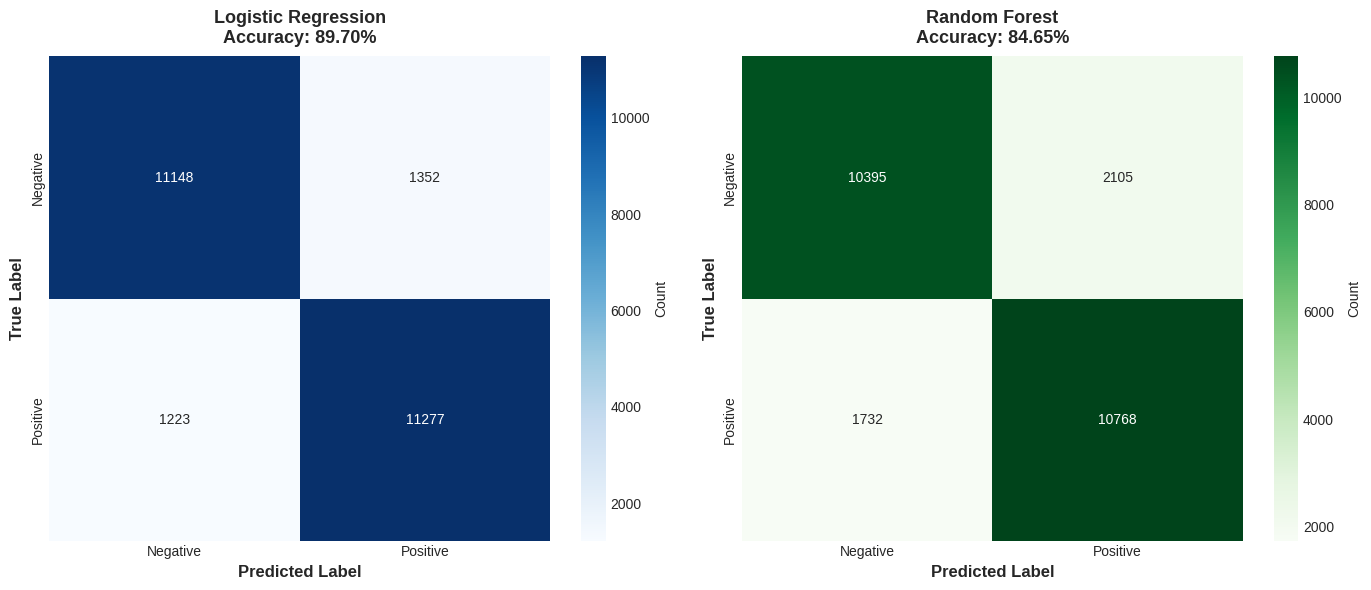

In [ ]:
print("Generating confusion matrices...")

lr_cm = confusion_matrix(y_test, lr_test_pred)
rf_cm = confusion_matrix(y_test, rf_test_pred)

# Creating visual
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title(f'Logistic Regression\nAccuracy: {lr_test_accuracy*100:.2f}%',
                 fontsize=13, fontweight='bold', pad=10)


# Random Forest Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title(f'Random Forest\nAccuracy: {rf_test_accuracy*100:.2f}%',
                 fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('tfidf_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

Generating ROC curves...
ROC curves saved as 'tfidf_roc_curves.png'


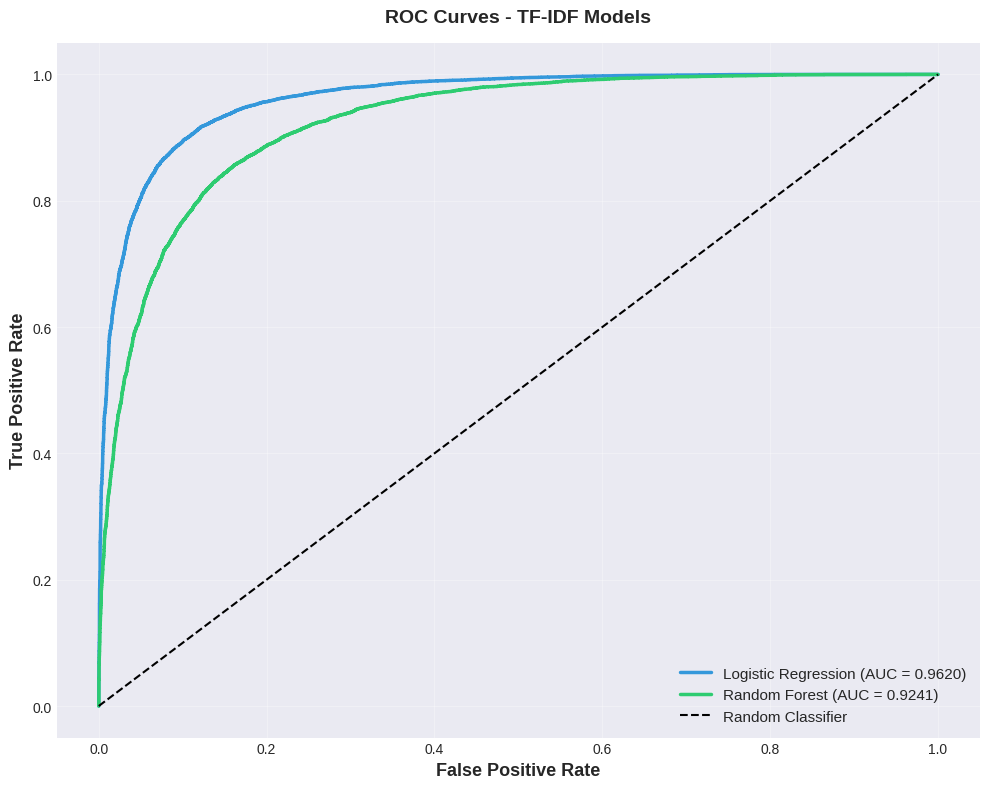

In [ ]:
print("Generating ROC curves...")

# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_pred_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_test_pred_proba)

lr_auc = roc_auc_score(y_test, lr_test_pred_proba)
rf_auc = roc_auc_score(y_test, rf_test_pred_proba)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, color='#3498db', linewidth=2.5,
         label=f'Logistic Regression (AUC = {lr_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, color='#2ecc71', linewidth=2.5,
         label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - TF-IDF Models', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tfidf_roc_curves.png', dpi=300, bbox_inches='tight')
print("ROC curves saved as 'tfidf_roc_curves.png'")
plt.show()

Creating performance comparison visualization...
Performance comparison saved as 'tfidf_performance_comparison.png'


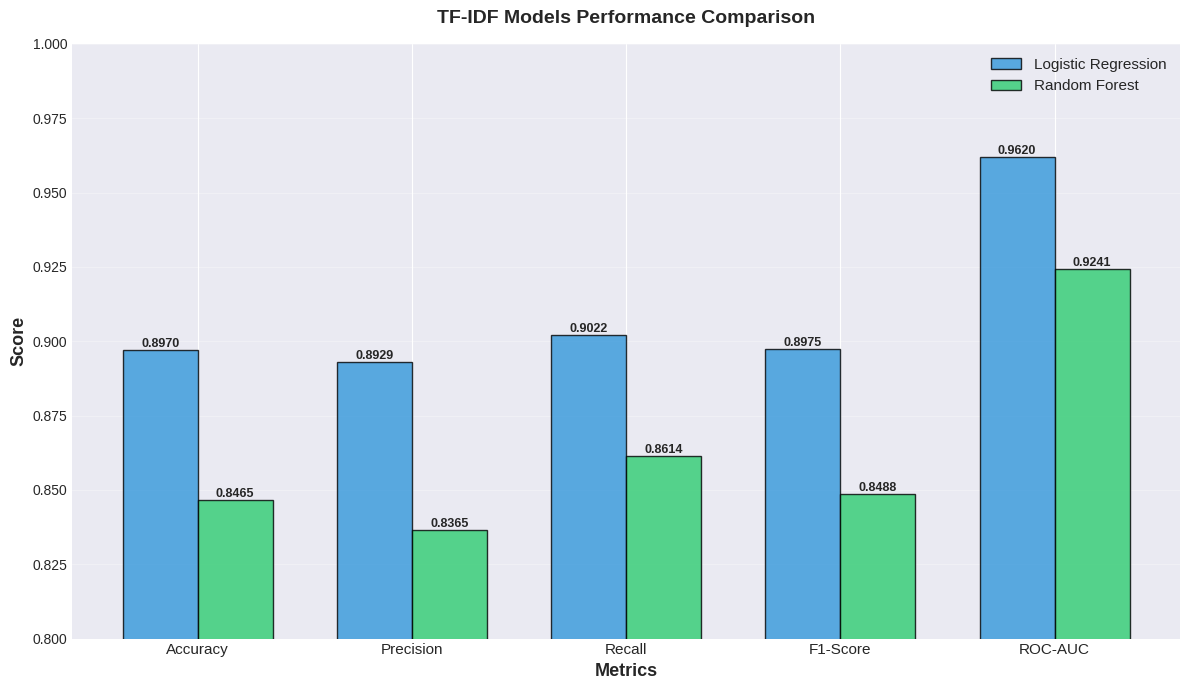

In [ ]:
print("Creating performance comparison visualization...")

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
lr_values = [lr_metrics[m] for m in metrics_to_plot]
rf_values = [rf_metrics[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression',
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, rf_values, width, label='Random Forest',
               color='#2ecc71', alpha=0.8, edgecolor='black')

ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('TF-IDF Models Performance Comparison', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('tfidf_performance_comparison.png', dpi=300, bbox_inches='tight')
print("Performance comparison saved as 'tfidf_performance_comparison.png'")
plt.show()

In [ ]:
print("Performing error analysis...")

# Finding misclassified examples
lr_misclassified = np.where(lr_test_pred != y_test)[0]
print(f"\nLogistic Regression misclassified: {len(lr_misclassified)} samples ({len(lr_misclassified)/len(y_test)*100:.2f}%)")

# Analyzing false positives and false negatives
lr_false_positives = np.where((lr_test_pred == 1) & (y_test == 0))[0]
lr_false_negatives = np.where((lr_test_pred == 0) & (y_test == 1))[0]

print(f"False Positives (predicted positive, actually negative): {len(lr_false_positives)}")
print(f"False Negatives (predicted negative, actually positive): {len(lr_false_negatives)}")

# Some examples of misclassifications
test_df_loaded = pd.read_pickle('test_preprocessed.pkl')

if len(lr_false_positives) > 0:
    print("\n> Example False Positive (LR predicted positive, actually negative) ---")
    fp_idx = lr_false_positives[0]
    print(f"Review: {test_df_loaded.iloc[fp_idx]['review'][:400]}...")
    print(f"Prediction confidence: {lr_test_pred_proba[fp_idx]:.4f}")

if len(lr_false_negatives) > 0:
    print("\n> Example False Negative (LR predicted negative, actually positive) ---")
    fn_idx = lr_false_negatives[0]
    print(f"Review: {test_df_loaded.iloc[fn_idx]['review'][:400]}...")
    print(f"Prediction confidence: {lr_test_pred_proba[fn_idx]:.4f}")

Performing error analysis...

Logistic Regression misclassified: 2575 samples (10.30%)
False Positives (predicted positive, actually negative): 1352
False Negatives (predicted negative, actually positive): 1223

> Example False Positive (LR predicted positive, actually negative) ---
Review: As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.<br /><br />And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bots, this is it! Watch this with a bunch of smart-ass wise-crackers, and you're in for a good ti...
Prediction confidence: 0.7584

> Example False Negative (LR predicted negative, actually positive) ---
Review: There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazi

In [ ]:
# Saving results summary

results_summary = {
    'models': {
        'logistic_regression': lr_metrics,
        'random_forest': rf_metrics
    },
    'training_times': {
        'logistic_regression': lr_train_time,
        'random_forest': rf_train_time
    },
    'confusion_matrices': {
        'logistic_regression': lr_cm.tolist(),
        'random_forest': rf_cm.tolist()
    },
    'misclassifications': {
        'logistic_regression': {
            'total': len(lr_misclassified),
            'false_positives': len(lr_false_positives),
            'false_negatives': len(lr_false_negatives)
        }
    }
}

with open('tfidf_results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

# Phase 9: Load Pre-trained Word2Vec Model

In [ ]:
X_train = train_df['cleaned_text'].values
y_train = train_df['sentiment'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['sentiment'].values

print(f"Data loaded successfully")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Data loaded successfully
Training samples: 25,000
Test samples: 25,000


In [ ]:
print("Checking for existing Word2Vec model...")

try:
    # Trying to load from file first (faster if already downloaded)
    word2vec_model = KeyedVectors.load('word2vec_googlenews.model')
    print("Loaded Word2Vec model from local file")
except:
    print("  Local model not found. Downloading from gensim...")
    print("  (This is a ~1.6GB download and may take 5-10 minutes)")

    start_time = time.time()
    word2vec_model = api.load('word2vec-google-news-300')
    download_time = time.time() - start_time

    print(f"Model downloaded in {download_time:.2f} seconds")

    # Saving for future use
    print("Saving model locally for future use...")
    word2vec_model.save('word2vec_googlenews.model')
    print("Model saved to 'word2vec_googlenews.model'")

print("\nWord2Vec model information:")
print(f"Vocabulary size: {len(word2vec_model):,} words")
print(f"Vector dimensions: {word2vec_model.vector_size}")
print(f"Model type: Pre-trained on Google News corpus")

Checking for existing Word2Vec model...
  Local model not found. Downloading from gensim...
  (This is a ~1.6GB download and may take 5-10 minutes)
Model downloaded in 78.13 seconds
Saving model locally for future use...
Model saved to 'word2vec_googlenews.model'

Word2Vec model information:
Vocabulary size: 3,000,000 words
Vector dimensions: 300
Model type: Pre-trained on Google News corpus


In [ ]:
# Testing the model with sample words
print("Testing Word2Vec with sample words...")

test_words = ['excellent', 'terrible', 'amazing', 'awful', 'good', 'bad']
print("\nSample word vectors (first 10 dimensions):")
for word in test_words:
    if word in word2vec_model:
        vector = word2vec_model[word][:10]
        print(f"  '{word}': [{', '.join([f'{v:.3f}' for v in vector])}, ...]")
    else:
        print(f"  '{word}': NOT IN VOCABULARY")

Testing Word2Vec with sample words...

Sample word vectors (first 10 dimensions):
  'excellent': [-0.213, -0.004, -0.181, -0.008, 0.113, 0.163, -0.015, -0.079, -0.164, 0.279, ...]
  'terrible': [0.164, 0.192, 0.092, 0.131, 0.075, 0.110, 0.048, 0.001, 0.271, 0.208, ...]
  'amazing': [0.074, 0.004, -0.136, 0.022, 0.181, -0.047, 0.225, -0.229, -0.040, 0.226, ...]
  'awful': [0.226, 0.099, -0.029, 0.143, -0.136, 0.216, -0.069, -0.048, 0.184, 0.301, ...]
  'good': [0.041, 0.062, -0.017, 0.079, 0.033, -0.013, 0.010, 0.124, -0.021, 0.152, ...]
  'bad': [0.063, 0.125, 0.113, 0.073, 0.039, 0.079, 0.051, 0.172, 0.096, 0.221, ...]


In [ ]:
# Finding similar words
print("Finding similar words (semantic relationships)...")
test_similarities = [
    ('excellent', ['fantastic', 'outstanding', 'wonderful']),
    ('terrible', ['awful', 'horrible', 'dreadful']),
    ('movie', ['film', 'cinema', 'picture'])
]

for word, expected_similar in test_similarities:
    if word in word2vec_model:
        similar = word2vec_model.most_similar(word, topn=5)
        print(f"\n  Words most similar to '{word}':")
        for similar_word, similarity in similar:
            print(f"    - {similar_word}: {similarity:.4f}")

Finding similar words (semantic relationships)...

  Words most similar to 'excellent':
    - terrific: 0.7410
    - superb: 0.7063
    - exceptional: 0.6815
    - fantastic: 0.6803
    - good: 0.6443

  Words most similar to 'terrible':
    - horrible: 0.9244
    - horrendous: 0.8467
    - dreadful: 0.8023
    - awful: 0.7479
    - horrid: 0.7179

  Words most similar to 'movie':
    - film: 0.8677
    - movies: 0.8013
    - films: 0.7363
    - moive: 0.6830
    - Movie: 0.6694


# PHASE 10: CREATE DOCUMENT EMBEDDINGS

In [ ]:
def document_vector(text, model, vector_size=300):
    """
    Convert a document to a vector by averaging word vectors.

    Argumentss:
        text: Preprocessed text string
        model: Word2Vec model
        vector_size: Dimension of word vectors (default 300)

    Returns:
        numpy array of shape (vector_size,)
    """

    # tokenize the text
    words = text.split()

    # get vectors for words in vocabulary
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])

    # return zero vector if no words are found
    if len(word_vectors) == 0:
        return np.zeros(vector_size)

    # Return the mean of word vectors
    return np.mean(word_vectors, axis=0)

In [ ]:
def create_document_embeddings(texts, model, vector_size=300):
    """
    Create document embeddings for a list of texts.
    Shows progress for large datasets.
    """
    embeddings = []
    oov_count = 0  # Out of vocabulary count
    total_words = 0
    words_found = 0

    print(f"  Processing {len(texts):,} documents...")

    for i, text in enumerate(texts):
        if (i + 1) % 2500 == 0:
            print(f"    Progress: {i+1:,}/{len(texts):,} ({(i+1)/len(texts)*100:.1f}%)")

        words = text.split()
        total_words += len(words)

        # Count words in vocabulary
        words_in_vocab = sum(1 for word in words if word in model)
        words_found += words_in_vocab

        if words_in_vocab == 0:
            oov_count += 1

        # Create document vector
        doc_vec = document_vector(text, model, vector_size)
        embeddings.append(doc_vec)

    embeddings_array = np.array(embeddings)

    # Statistics
    vocab_coverage = (words_found / total_words * 100) if total_words > 0 else 0

    print(f"\nStatistics:")
    print(f"Total documents: {len(texts):,}")
    print(f"Documents with no words in vocabulary: {oov_count} ({oov_count/len(texts)*100:.2f}%)")
    print(f"Total words processed: {total_words:,}")
    print(f"Words found in Word2Vec: {words_found:,} ({vocab_coverage:.2f}%)")
    print(f"Embedding shape: {embeddings_array.shape}")

    return embeddings_array, vocab_coverage

In [ ]:
# Creating embeddings for training data
print("Creating Word2Vec embeddings for TRAINING data...")
start_time = time.time()
train_embeddings, train_coverage = create_document_embeddings(X_train, word2vec_model)
train_time = time.time() - start_time
print(f"Training embeddings created in {train_time:.2f} seconds")

# Creating embeddings for test data
print("Creating Word2Vec embeddings for TEST data...")
start_time = time.time()
test_embeddings, test_coverage = create_document_embeddings(X_test, word2vec_model)
test_time = time.time() - start_time
print(f"Test embeddings created in {test_time:.2f} seconds")

Creating Word2Vec embeddings for TRAINING data...
  Processing 25,000 documents...
    Progress: 2,500/25,000 (10.0%)
    Progress: 5,000/25,000 (20.0%)
    Progress: 7,500/25,000 (30.0%)
    Progress: 10,000/25,000 (40.0%)
    Progress: 12,500/25,000 (50.0%)
    Progress: 15,000/25,000 (60.0%)
    Progress: 17,500/25,000 (70.0%)
    Progress: 20,000/25,000 (80.0%)
    Progress: 22,500/25,000 (90.0%)
    Progress: 25,000/25,000 (100.0%)

Statistics:
Total documents: 25,000
Documents with no words in vocabulary: 0 (0.00%)
Total words processed: 5,922,763
Words found in Word2Vec: 5,214,269 (88.04%)
Embedding shape: (25000, 300)
Training embeddings created in 19.44 seconds
Creating Word2Vec embeddings for TEST data...
  Processing 25,000 documents...
    Progress: 2,500/25,000 (10.0%)
    Progress: 5,000/25,000 (20.0%)
    Progress: 7,500/25,000 (30.0%)
    Progress: 10,000/25,000 (40.0%)
    Progress: 12,500/25,000 (50.0%)
    Progress: 15,000/25,000 (60.0%)
    Progress: 17,500/25,000 (

In [ ]:
# Verify embeddings
print("Verifying embeddings...")
print(f"Training embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"No NaN values in training: {not np.isnan(train_embeddings).any()}")
print(f"No NaN values in test: {not np.isnan(test_embeddings).any()}")

Verifying embeddings...
Training embeddings shape: (25000, 300)
Test embeddings shape: (25000, 300)
No NaN values in training: True
No NaN values in test: True


In [ ]:
# Showing sample embedding statistics
print("Sample embedding statistics:")
print(f"Mean value: {train_embeddings.mean():.4f}")
print(f"Std deviation: {train_embeddings.std():.4f}")
print(f"Min value: {train_embeddings.min():.4f}")
print(f"Max value: {train_embeddings.max():.4f}")

Sample embedding statistics:
Mean value: -0.0011
Std deviation: 0.0490
Min value: -0.2199
Max value: 0.2363


In [ ]:
# Saving embeddings
print("Saving Word2Vec embeddings...")
with open('word2vec_embeddings.pkl', 'wb') as f:
    pickle.dump({
        'train': train_embeddings,
        'test': test_embeddings,
        'y_train': y_train,
        'y_test': y_test,
        'train_coverage': train_coverage,
        'test_coverage': test_coverage
    }, f)
print("Embeddings saved to 'word2vec_embeddings.pkl'")

Saving Word2Vec embeddings...
Embeddings saved to 'word2vec_embeddings.pkl'


# PHASE 11: WORD2VEC MODEL TRAINING

## Model 1: Logistic Regression

In [ ]:
print("Initializing Logistic Regression for Word2Vec features...")

# Using same parameters as TF-IDF for a fair comparison
w2v_lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='liblinear',
    random_state=42,
    n_jobs=-1
)

print("Model initialized with same parameters as TF-IDF approach")
print(f"max_iter: 1000")
print(f"C (inverse regularization): 1.0")
print(f"solver: liblinear")

Initializing Logistic Regression for Word2Vec features...
Model initialized with same parameters as TF-IDF approach
max_iter: 1000
C (inverse regularization): 1.0
solver: liblinear


In [ ]:
print("Training Logistic Regression on Word2Vec embeddings...")
start_time = time.time()
w2v_lr_model.fit(train_embeddings, y_train)
w2v_train_time = time.time() - start_time

print(f"Model trained successfully in {w2v_train_time:.2f} seconds")

Training Logistic Regression on Word2Vec embeddings...
Model trained successfully in 2.36 seconds


In [ ]:
print("Making predictions on training set...")
w2v_lr_train_pred = w2v_lr_model.predict(train_embeddings)
w2v_lr_train_accuracy = accuracy_score(y_train, w2v_lr_train_pred)
print(f"Training accuracy: {w2v_lr_train_accuracy*100:.2f}%")

Making predictions on training set...
Training accuracy: 85.07%


In [ ]:
print("Making predictions on test set...")
w2v_lr_test_pred = w2v_lr_model.predict(test_embeddings)
w2v_lr_test_pred_proba = w2v_lr_model.predict_proba(test_embeddings)[:, 1]
w2v_lr_test_accuracy = accuracy_score(y_test, w2v_lr_test_pred)
print(f"Test accuracy: {w2v_lr_test_accuracy*100:.2f}%")

Making predictions on test set...
Test accuracy: 84.76%


In [ ]:
# Save model
print("Saving Word2Vec model...")
with open('lr_word2vec_model.pkl', 'wb') as f:
    pickle.dump(w2v_lr_model, f)
print("Model saved to 'lr_word2vec_model.pkl'")

Saving Word2Vec model...
Model saved to 'lr_word2vec_model.pkl'


## Model 2: Random Forest Classifier

In [ ]:
print("Initializing Random Forest for Word2Vec features...")
w2v_rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=50,             # Maximum depth of trees
    min_samples_split=5,      # Minimum samples to split
    min_samples_leaf=2,       # Minimum samples in leaf
    random_state=42,
    n_jobs=-1,                # Use all CPU cores
    verbose=0
)

print("Model initialized with same parameters as TF-IDF approach")
print(f"n_estimators: 100 trees")
print(f"max_depth: 50")
print(f"min_samples_split: 5")
print(f"min_samples_leaf: 2")

Initializing Random Forest for Word2Vec features...
Model initialized with same parameters as TF-IDF approach
n_estimators: 100 trees
max_depth: 50
min_samples_split: 5
min_samples_leaf: 2


In [ ]:
print("Training Random Forest on Word2Vec embeddings...")

start_time = time.time()
w2v_rf_model.fit(train_embeddings, y_train)
w2v_rf_train_time = time.time() - start_time

print(f"Model trained successfully in {w2v_rf_train_time:.2f} seconds")

Training Random Forest on Word2Vec embeddings...
Model trained successfully in 54.85 seconds


In [ ]:
print("Making predictions...")
w2v_rf_train_pred = w2v_rf_model.predict(train_embeddings)
w2v_rf_test_pred = w2v_rf_model.predict(test_embeddings)
w2v_rf_test_pred_proba = w2v_rf_model.predict_proba(test_embeddings)[:, 1]

w2v_rf_train_accuracy = accuracy_score(y_train, w2v_rf_train_pred)
w2v_rf_test_accuracy = accuracy_score(y_test, w2v_rf_test_pred)

print(f"Training accuracy: {w2v_rf_train_accuracy*100:.2f}%")
print(f"Test accuracy: {w2v_rf_test_accuracy*100:.2f}%")

Making predictions...
Training accuracy: 99.95%
Test accuracy: 80.96%


In [ ]:
# Saving random forest model
print("\n[4/3] Saving Random Forest model...")
with open('rf_word2vec_model.pkl', 'wb') as f:
    pickle.dump(w2v_rf_model, f)
print("✓ Model saved to 'rf_word2vec_model.pkl'")


[4/3] Saving Random Forest model...
✓ Model saved to 'rf_word2vec_model.pkl'


# PHASE 12: WORD2VEC MODEL EVALUATION

In [ ]:
def calculate_w2v_metrics(y_true, y_pred, y_pred_proba, model_name):
    """Calculate comprehensive evaluation metrics"""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }
    return metrics

In [ ]:
# Calculating metrics for both models
w2v_lr_metrics = calculate_w2v_metrics(y_test, w2v_lr_test_pred, w2v_lr_test_pred_proba,
                                        'Word2Vec + Logistic Regression')
w2v_rf_metrics = calculate_w2v_metrics(y_test, w2v_rf_test_pred, w2v_rf_test_pred_proba,
                                        'Word2Vec + Random Forest')

# Creating a results DataFrame
w2v_results_df = pd.DataFrame([w2v_lr_metrics, w2v_rf_metrics])

print("WORD2VEC MODEL PERFORMANCE COMPARISON")
print(w2v_results_df.to_string(index=False))

WORD2VEC MODEL PERFORMANCE COMPARISON
                         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Word2Vec + Logistic Regression   0.84760   0.854636 0.83768  0.846073 0.921979
      Word2Vec + Random Forest   0.80956   0.804373 0.81808  0.811169 0.889945


In [ ]:
print("Generating classification reports...")

print("LOGISTIC REGRESSION - Classification Report")

print(classification_report(y_test, w2v_lr_test_pred,
                          target_names=['Negative', 'Positive'],
                          digits=4))

print("RANDOM FOREST - Classification Report")

print(classification_report(y_test, w2v_rf_test_pred,
                          target_names=['Negative', 'Positive'],
                          digits=4))

Generating classification reports...
LOGISTIC REGRESSION - Classification Report
              precision    recall  f1-score   support

    Negative     0.8408    0.8575    0.8491     12500
    Positive     0.8546    0.8377    0.8461     12500

    accuracy                         0.8476     25000
   macro avg     0.8477    0.8476    0.8476     25000
weighted avg     0.8477    0.8476    0.8476     25000

RANDOM FOREST - Classification Report
              precision    recall  f1-score   support

    Negative     0.8149    0.8010    0.8079     12500
    Positive     0.8044    0.8181    0.8112     12500

    accuracy                         0.8096     25000
   macro avg     0.8096    0.8096    0.8095     25000
weighted avg     0.8096    0.8096    0.8095     25000



Generating confusion matrices...
Confusion matrices saved as 'word2vec_confusion_matrices.png'


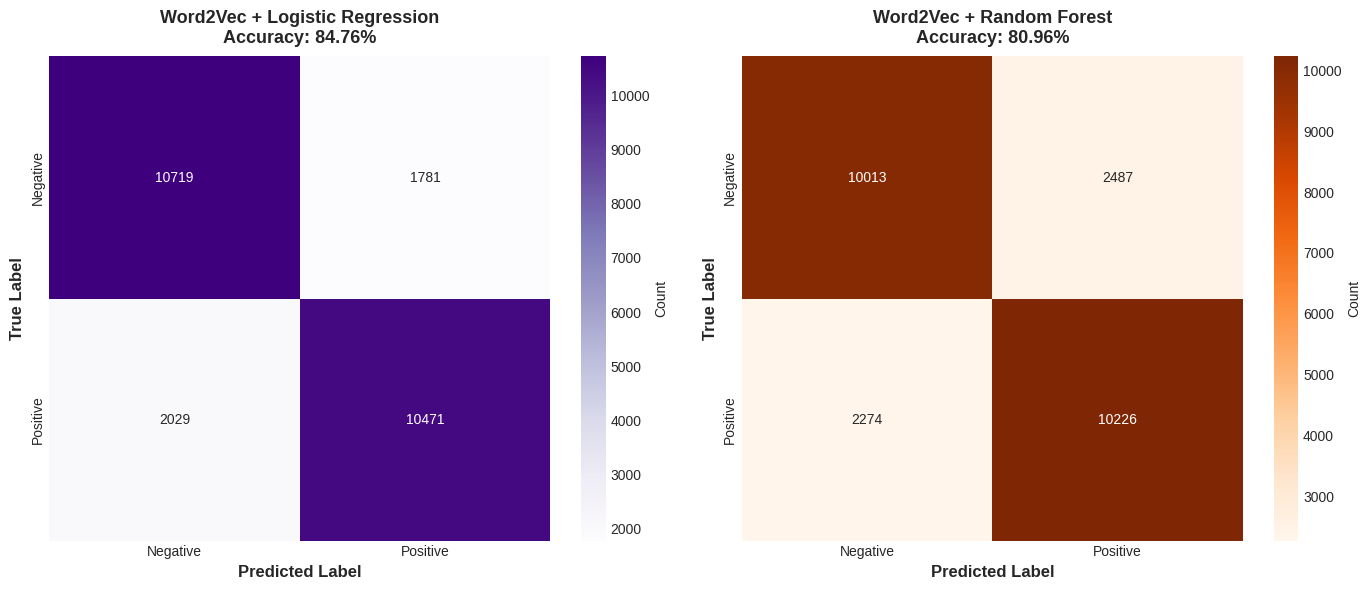

In [ ]:
print("Generating confusion matrices...")

w2v_lr_cm = confusion_matrix(y_test, w2v_lr_test_pred)
w2v_rf_cm = confusion_matrix(y_test, w2v_rf_test_pred)

# Creating visual
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(w2v_lr_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title(f'Word2Vec + Logistic Regression\nAccuracy: {w2v_lr_test_accuracy*100:.2f}%',
                  fontsize=13, fontweight='bold', pad=10)

# Random Forest Confusion Matrix
sns.heatmap(w2v_rf_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title(f'Word2Vec + Random Forest\nAccuracy: {w2v_rf_test_accuracy*100:.2f}%',
                  fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('word2vec_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Confusion matrices saved as 'word2vec_confusion_matrices.png'")
plt.show()

ROC curves saved as 'word2vec_roc_curves.png'


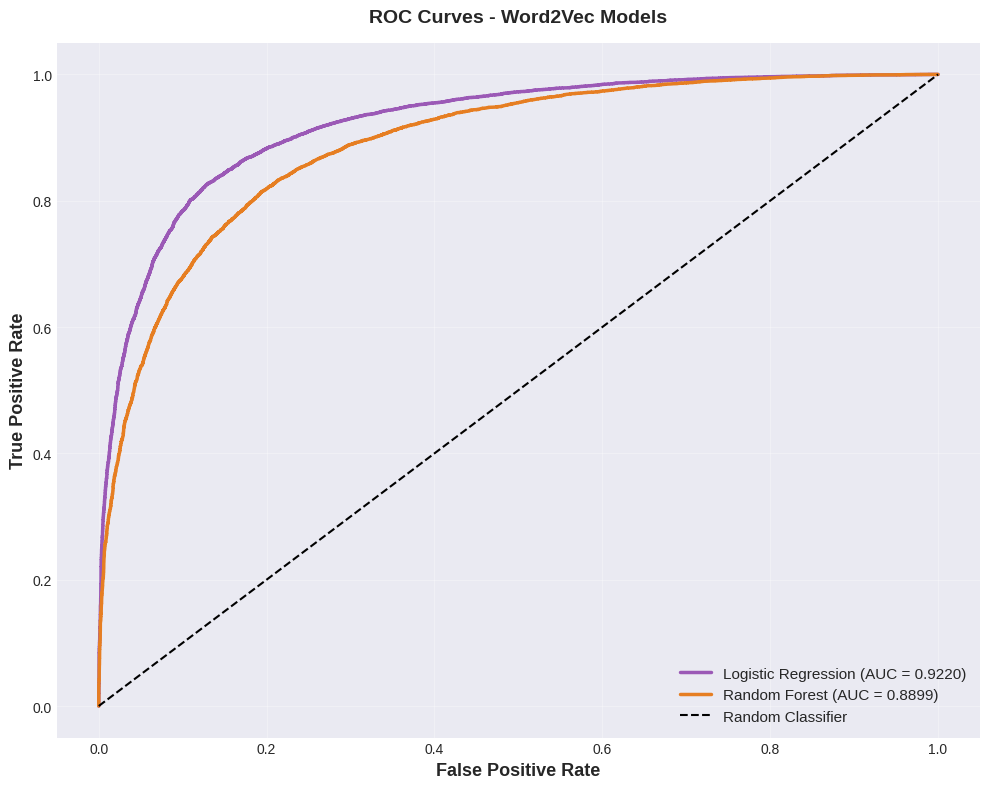

In [ ]:
# ROC Curve

w2v_lr_fpr, w2v_lr_tpr, _ = roc_curve(y_test, w2v_lr_test_pred_proba)
w2v_rf_fpr, w2v_rf_tpr, _ = roc_curve(y_test, w2v_rf_test_pred_proba)

w2v_lr_auc = roc_auc_score(y_test, w2v_lr_test_pred_proba)
w2v_rf_auc = roc_auc_score(y_test, w2v_rf_test_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(w2v_lr_fpr, w2v_lr_tpr, color='#9b59b6', linewidth=2.5,
         label=f'Logistic Regression (AUC = {w2v_lr_auc:.4f})')
plt.plot(w2v_rf_fpr, w2v_rf_tpr, color='#e67e22', linewidth=2.5,
         label=f'Random Forest (AUC = {w2v_rf_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - Word2Vec Models', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('word2vec_roc_curves.png', dpi=300, bbox_inches='tight')
print("ROC curves saved as 'word2vec_roc_curves.png'")
plt.show()

Creating performance comparison visualization...
Performance comparison saved as 'word2vec_performance_comparison.png'


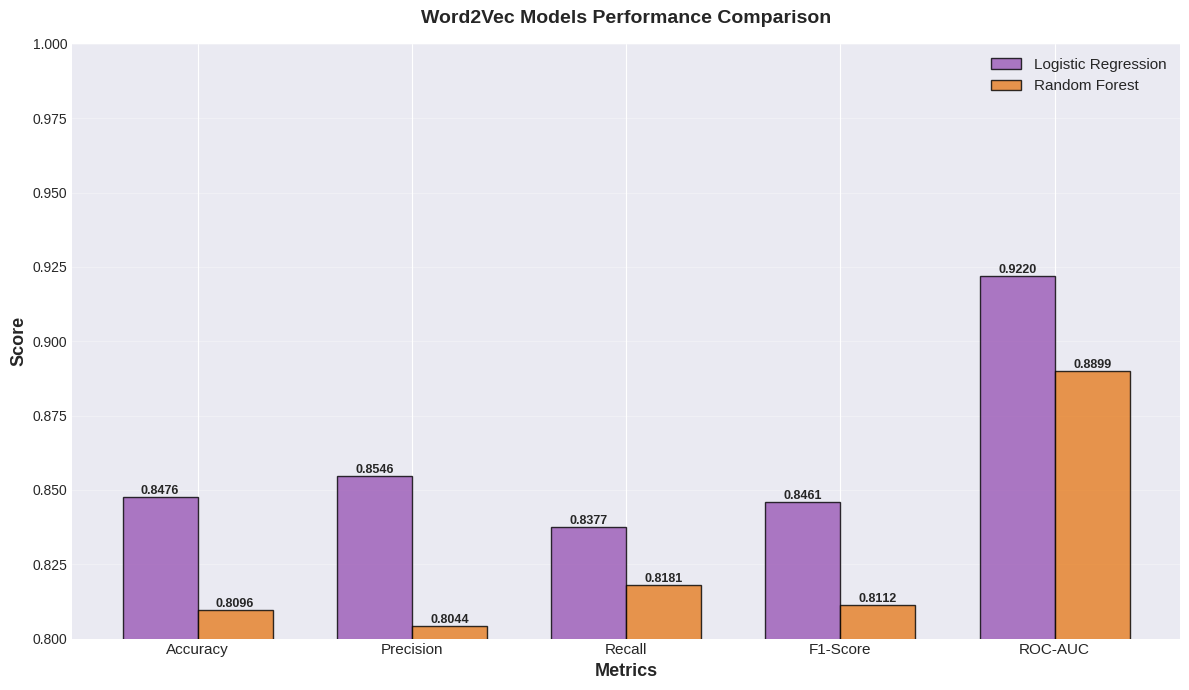

In [ ]:
# Performance Comparison Visual
print("Creating performance comparison visualization...")

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
lr_values = [w2v_lr_metrics[m] for m in metrics_to_plot]
rf_values = [w2v_rf_metrics[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression',
               color='#9b59b6', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, rf_values, width, label='Random Forest',
               color='#e67e22', alpha=0.8, edgecolor='black')

ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Word2Vec Models Performance Comparison', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

# Adding value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('word2vec_performance_comparison.png', dpi=300, bbox_inches='tight')
print("Performance comparison saved as 'word2vec_performance_comparison.png'")
plt.show()

In [ ]:
# Error Analysis

# Finding misclassified examples for Logistic Regression
w2v_lr_misclassified = np.where(w2v_lr_test_pred != y_test)[0]
print(f"\nLogistic Regression misclassified: {len(w2v_lr_misclassified)} samples ({len(w2v_lr_misclassified)/len(y_test)*100:.2f}%)")

# Analyzing false positives and false negatives
w2v_lr_false_positives = np.where((w2v_lr_test_pred == 1) & (y_test == 0))[0]
w2v_lr_false_negatives = np.where((w2v_lr_test_pred == 0) & (y_test == 1))[0]

print(f"False Positives (predicted positive, actually negative): {len(w2v_lr_false_positives)}")
print(f"False Negatives (predicted negative, actually positive): {len(w2v_lr_false_negatives)}")

# Find misclassified examples for Random Forest
w2v_rf_misclassified = np.where(w2v_rf_test_pred != y_test)[0]
print(f"\nRandom Forest misclassified: {len(w2v_rf_misclassified)} samples ({len(w2v_rf_misclassified)/len(y_test)*100:.2f}%)")

w2v_rf_false_positives = np.where((w2v_rf_test_pred == 1) & (y_test == 0))[0]
w2v_rf_false_negatives = np.where((w2v_rf_test_pred == 0) & (y_test == 1))[0]

print(f"False Positives: {len(w2v_rf_false_positives)}")
print(f"False Negatives: {len(w2v_rf_false_negatives)}")


Logistic Regression misclassified: 3810 samples (15.24%)
False Positives (predicted positive, actually negative): 1781
False Negatives (predicted negative, actually positive): 2029

Random Forest misclassified: 4761 samples (19.04%)
False Positives: 2487
False Negatives: 2274


In [ ]:
# Some examples (using LR results) of false positives and false negatives
if len(w2v_lr_false_positives) > 0:
    print("\n--- Example False Positive (LR predicted positive, actually negative) ---")
    fp_idx = w2v_lr_false_positives[0]
    print(f"Review: {test_df.iloc[fp_idx]['review'][:400]}...")
    print(f"Prediction confidence: {w2v_lr_test_pred_proba[fp_idx]:.4f}")

if len(w2v_lr_false_negatives) > 0:
    print("\n--- Example False Negative (LR predicted negative, actually positive) ---")
    fn_idx = w2v_lr_false_negatives[0]
    print(f"Review: {test_df.iloc[fn_idx]['review'][:400]}...")
    print(f"Prediction confidence: {w2v_lr_test_pred_proba[fn_idx]:.4f}")


--- Example False Positive (LR predicted positive, actually negative) ---
Review: As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.<br /><br />And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bots, this is it! Watch this with a bunch of smart-ass wise-crackers, and you're in for a good ti...
Prediction confidence: 0.5838

--- Example False Negative (LR predicted negative, actually positive) ---
Review: This classic has so many great one-liners and unintentionally hilarious scenes that I don't even know where to start. If you want advice on dating, its here. Just totally ignore the person you want, and then spout out classic lines like "Chicken's good...I like Chicken", and before you know it you will be having a one-nighter in a basement (it's a NICE basement) with a woman who is 35 years younge

In [ ]:
# Saving word2vec results

w2v_results = {
    'models': {
        'logistic_regression': w2v_lr_metrics,
        'random_forest': w2v_rf_metrics
    },
    'training_times': {
        'logistic_regression': w2v_train_time,
        'random_forest': w2v_rf_train_time
    },
    'confusion_matrices': {
        'logistic_regression': w2v_lr_cm.tolist(),
        'random_forest': w2v_rf_cm.tolist()
    },
    'vocabulary_coverage': {
        'train': train_coverage,
        'test': test_coverage
    },
    'misclassifications': {
        'logistic_regression': {
            'total': len(w2v_lr_misclassified),
            'false_positives': len(w2v_lr_false_positives),
            'false_negatives': len(w2v_lr_false_negatives)
        },
        'random_forest': {
            'total': len(w2v_rf_misclassified),
            'false_positives': len(w2v_rf_false_positives),
            'false_negatives': len(w2v_rf_false_negatives)
        }
    }
}

with open('word2vec_results.pkl', 'wb') as f:
    pickle.dump(w2v_results, f)

# PHASE 13: PERFORMANCE COMPARISON & HYPOTHESIS TESTING

In [ ]:
# Load TF-IDF results
with open('tfidf_results_summary.pkl', 'rb') as f:
    tfidf_results = pickle.load(f)

# Load Word2Vec results
with open('word2vec_results.pkl', 'rb') as f:
    w2v_results = pickle.load(f)

# Load test data for analysis
test_df = pd.read_pickle('test_preprocessed.pkl')
y_test = test_df['sentiment'].values

In [ ]:
# Creating comprehensive comparison table

# Extract metrics for all models
models_comparison = pd.DataFrame([
    tfidf_results['models']['logistic_regression'],
    tfidf_results['models']['random_forest'],
    w2v_results['models']['logistic_regression'],
    w2v_results['models']['random_forest']
])

# Reorder columns for better readability
models_comparison = models_comparison[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

print("COMPLETE MODEL PERFORMANCE COMPARISON")
print(models_comparison.to_string(index=False))

COMPLETE MODEL PERFORMANCE COMPARISON
                         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           Logistic Regression   0.89700   0.892945 0.90216  0.897529 0.961983
                 Random Forest   0.84652   0.836479 0.86144  0.848776 0.924148
Word2Vec + Logistic Regression   0.84760   0.854636 0.83768  0.846073 0.921979
      Word2Vec + Random Forest   0.80956   0.804373 0.81808  0.811169 0.889945


In [ ]:
# Finding best model for each metric
print("Best Model by Metric:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = models_comparison[metric].idxmax()
    best_model = models_comparison.loc[best_idx, 'Model']
    best_value = models_comparison.loc[best_idx, metric]
    print(f"  {metric:15s}: {best_model:40s} ({best_value:.4f})")

Best Model by Metric:
  Accuracy       : Logistic Regression                      (0.8970)
  Precision      : Logistic Regression                      (0.8929)
  Recall         : Logistic Regression                      (0.9022)
  F1-Score       : Logistic Regression                      (0.8975)
  ROC-AUC        : Logistic Regression                      (0.9620)


In [ ]:
# Calculating performance differences

# Best TF-IDF model
tfidf_best_acc = max(tfidf_results['models']['logistic_regression']['Accuracy'],
                     tfidf_results['models']['random_forest']['Accuracy'])
tfidf_best_f1 = max(tfidf_results['models']['logistic_regression']['F1-Score'],
                    tfidf_results['models']['random_forest']['F1-Score'])

# Best Word2Vec model
w2v_best_acc = max(w2v_results['models']['logistic_regression']['Accuracy'],
                   w2v_results['models']['random_forest']['Accuracy'])
w2v_best_f1 = max(w2v_results['models']['logistic_regression']['F1-Score'],
                  w2v_results['models']['random_forest']['F1-Score'])

# Calculate differences
acc_difference = (w2v_best_acc - tfidf_best_acc) * 100  # Percentage points
f1_difference = (w2v_best_f1 - tfidf_best_f1) * 100

print("HYPOTHESIS TESTING: Word2Vec vs TF-IDF")
print(f"\nOriginal Hypothesis: Word2Vec will achieve 5-10% higher accuracy than TF-IDF")
print(f"\nActual Results:")
print(f"> Best TF-IDF Accuracy:    {tfidf_best_acc*100:.2f}%")
print(f"> Best Word2Vec Accuracy:  {w2v_best_acc*100:.2f}%")
print(f"> Difference:              {acc_difference:+.2f} percentage points")
print(f"\n> Best TF-IDF F1-Score:    {tfidf_best_f1:.4f}")
print(f"> Best Word2Vec F1-Score:  {w2v_best_f1:.4f}")
print(f"> Difference:              {f1_difference:+.2f} percentage points")

if acc_difference > 0:
    print(f"\nWord2Vec outperformed TF-IDF by {acc_difference:.2f} percentage points")
    if 5 <= acc_difference <= 10:
        print("> Hypothesis CONFIRMED: Improvement is within predicted 5-10% range")
    elif acc_difference > 10:
        print("> Hypothesis EXCEEDED: Improvement is greater than predicted 10%")
    else:
        print(f"> Hypothesis PARTIALLY CONFIRMED: Improvement ({acc_difference:.2f}%) is less than predicted 5%")
else:
    print(f"\nHypothesis REJECTED: TF-IDF outperformed Word2Vec by {abs(acc_difference):.2f} percentage points")
    print("This suggests domain-specific features (TF-IDF) are more valuable than general embeddings for this task")


HYPOTHESIS TESTING: Word2Vec vs TF-IDF

Original Hypothesis: Word2Vec will achieve 5-10% higher accuracy than TF-IDF

Actual Results:
> Best TF-IDF Accuracy:    89.70%
> Best Word2Vec Accuracy:  84.76%
> Difference:              -4.94 percentage points

> Best TF-IDF F1-Score:    0.8975
> Best Word2Vec F1-Score:  0.8461
> Difference:              -5.15 percentage points

Hypothesis REJECTED: TF-IDF outperformed Word2Vec by 4.94 percentage points
This suggests domain-specific features (TF-IDF) are more valuable than general embeddings for this task


In [ ]:
# Training time comparison

training_times = pd.DataFrame({
    'Model': [
        'TF-IDF + Logistic Regression',
        'TF-IDF + Random Forest',
        'Word2Vec + Logistic Regression',
        'Word2Vec + Random Forest'
    ],
    'Training Time (seconds)': [
        tfidf_results['training_times']['logistic_regression'],
        tfidf_results['training_times']['random_forest'],
        w2v_results['training_times']['logistic_regression'],
        w2v_results['training_times']['random_forest']
    ]
})

print("TRAINING TIME COMPARISON")
print(training_times.to_string(index=False))

TRAINING TIME COMPARISON
                         Model  Training Time (seconds)
  TF-IDF + Logistic Regression                 2.534698
        TF-IDF + Random Forest                57.653105
Word2Vec + Logistic Regression                 2.360976
      Word2Vec + Random Forest                54.851187


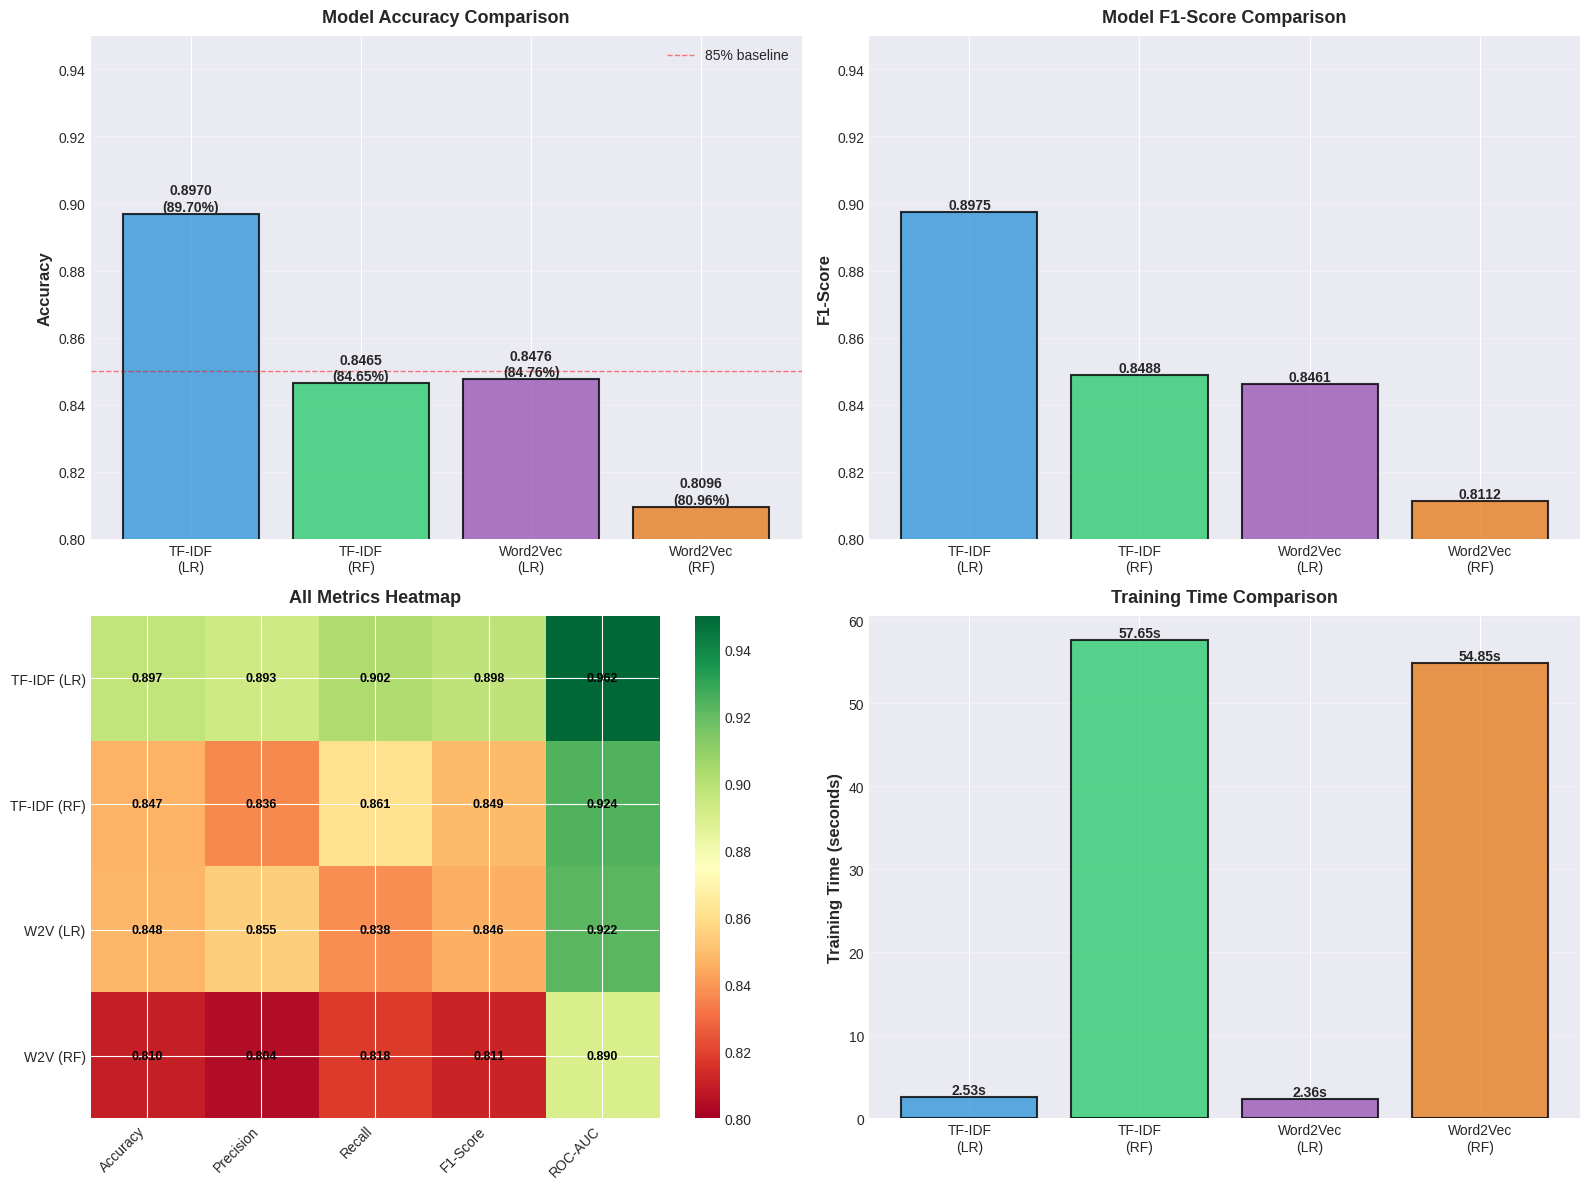

In [ ]:
# Visualization 1: Overall Performance Comparison

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
models = ['TF-IDF\n(LR)', 'TF-IDF\n(RF)', 'Word2Vec\n(LR)', 'Word2Vec\n(RF)']
accuracies = models_comparison['Accuracy'].values
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']

bars = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=13, fontweight='bold', pad=10)
ax1.set_ylim([0.80, 0.95])
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.85, color='red', linestyle='--', linewidth=1, alpha=0.5, label='85% baseline')

# Including value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({height*100:.2f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.legend()

# Plot 2: F1-Score Comparison
ax2 = axes[0, 1]
f1_scores = models_comparison['F1-Score'].values

bars = ax2.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Model F1-Score Comparison', fontsize=13, fontweight='bold', pad=10)
ax2.set_ylim([0.80, 0.95])
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')


# Plot 3: All Metrics Comparison (Heatmap)
ax3 = axes[1, 0]
metrics_data = models_comparison[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].values
model_labels = ['TF-IDF (LR)', 'TF-IDF (RF)', 'W2V (LR)', 'W2V (RF)']

im = ax3.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0.80, vmax=0.95)
ax3.set_xticks(range(5))
ax3.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'], rotation=45, ha='right')
ax3.set_yticks(range(4))
ax3.set_yticklabels(model_labels)
ax3.set_title('All Metrics Heatmap', fontsize=13, fontweight='bold', pad=10)

# Add values to heatmap
for i in range(4):
    for j in range(5):
        text = ax3.text(j, i, f'{metrics_data[i, j]:.3f}',
                       ha='center', va='center', color='black', fontweight='bold', fontsize=9)

plt.colorbar(im, ax=ax3)

# Plot 4: Training Time Comparison
ax4 = axes[1, 1]
times = training_times['Training Time (seconds)'].values

bars = ax4.bar(models, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Training Time Comparison', fontsize=13, fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Creating TF-IDF vs Word2Vec direct comparison...


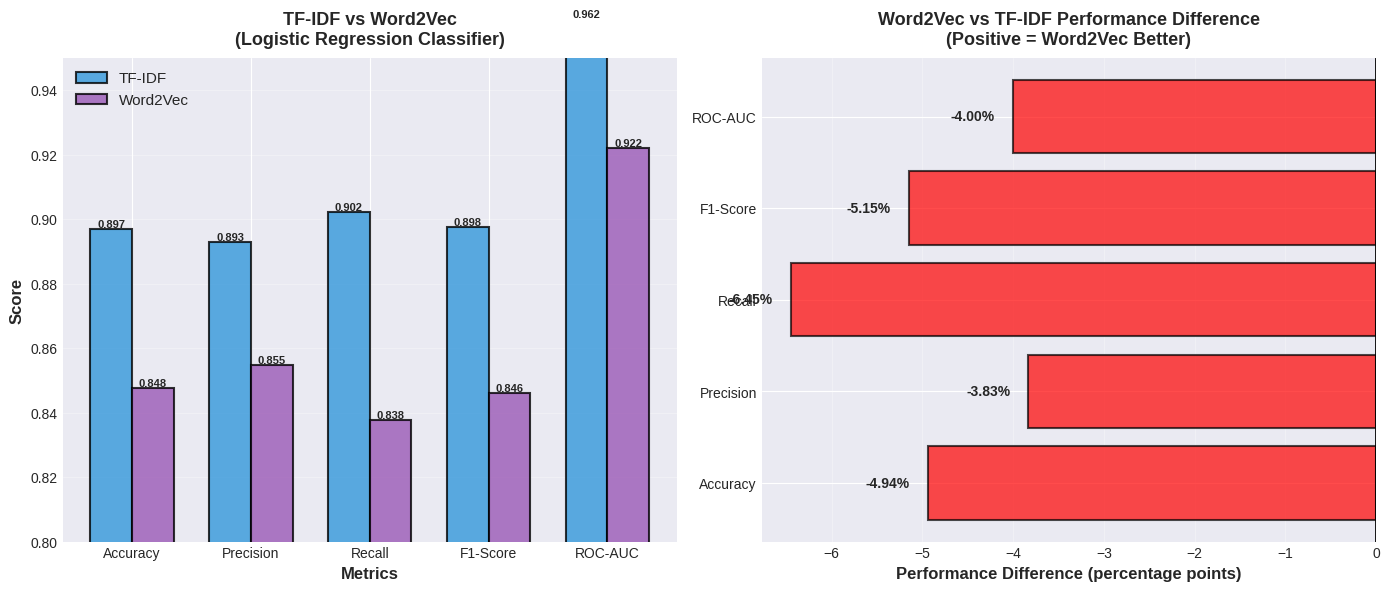

In [ ]:
# Visualization 2: TF-IDF vs Word2Vec Direct Comparison

print("Creating TF-IDF vs Word2Vec direct comparison...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Comparing best models from each approach
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Using Logistic Regression for fair comparison (same classifier)
tfidf_lr_values = [tfidf_results['models']['logistic_regression'][m] for m in metrics]
w2v_lr_values = [w2v_results['models']['logistic_regression'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, tfidf_lr_values, width, label='TF-IDF',
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, w2v_lr_values, width, label='Word2Vec',
                color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('TF-IDF vs Word2Vec\n(Logistic Regression Classifier)',
              fontsize=13, fontweight='bold', pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=10)
ax1.legend(fontsize=11)
ax1.set_ylim([0.80, 0.95])
ax1.grid(axis='y', alpha=0.3)

# Including value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# Performance difference visualization
differences = [(w2v - tfidf) * 100 for tfidf, w2v in zip(tfidf_lr_values, w2v_lr_values)]
colors_diff = ['green' if d > 0 else 'red' for d in differences]

bars = ax2.barh(metrics, differences, color=colors_diff, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax2.set_xlabel('Performance Difference (percentage points)', fontsize=12, fontweight='bold')
ax2.set_title('Word2Vec vs TF-IDF Performance Difference\n(Positive = Word2Vec Better)',
              fontsize=13, fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3)

# Including value labels
for i, (bar, diff) in enumerate(zip(bars, differences)):
    width = bar.get_width()
    label_x = width + (0.2 if width > 0 else -0.2)
    ax2.text(label_x, i, f'{diff:+.2f}%',
            ha='left' if width > 0 else 'right', va='center',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('tfidf_vs_word2vec_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Statistical Significance Testing

print("Performing statistical significance testing...")

# Loading predictions for statistical testing
with open('tfidf_matrices.pkl', 'rb') as f:
    tfidf_data = pickle.load(f)

with open('word2vec_embeddings.pkl', 'rb') as f:
    w2v_data = pickle.load(f)

# Loading models
with open('lr_tfidf_model.pkl', 'rb') as f:
    lr_tfidf_model = pickle.load(f)

with open('lr_word2vec_model.pkl', 'rb') as f:
    lr_w2v_model = pickle.load(f)

# Getting predictions
tfidf_pred = lr_tfidf_model.predict(tfidf_data['test'])
w2v_pred = lr_w2v_model.predict(w2v_data['test'])

# Calculating per-sample correctness
tfidf_correct = (tfidf_pred == y_test).astype(int)
w2v_correct = (w2v_pred == y_test).astype(int)

# McNemar's test (for paired binary outcomes)
from scipy.stats import chi2

# Contingency table: both_correct, tfidf_only, w2v_only, both_wrong
both_correct = np.sum((tfidf_correct == 1) & (w2v_correct == 1))
tfidf_only = np.sum((tfidf_correct == 1) & (w2v_correct == 0))
w2v_only = np.sum((tfidf_correct == 0) & (w2v_correct == 1))
both_wrong = np.sum((tfidf_correct == 0) & (w2v_correct == 0))

print("STATISTICAL SIGNIFICANCE TESTING")
print(f"\nContingency Table:")
print(f"  Both models correct:     {both_correct:,} ({both_correct/len(y_test)*100:.2f}%)")
print(f"  Only TF-IDF correct:     {tfidf_only:,} ({tfidf_only/len(y_test)*100:.2f}%)")
print(f"  Only Word2Vec correct:   {w2v_only:,} ({w2v_only/len(y_test)*100:.2f}%)")
print(f"  Both models wrong:       {both_wrong:,} ({both_wrong/len(y_test)*100:.2f}%)")

# McNemar's test statistic
n_discordant = tfidf_only + w2v_only
if n_discordant > 0:
    mcnemar_stat = (abs(tfidf_only - w2v_only) - 1)**2 / n_discordant
    p_value = 1 - chi2.cdf(mcnemar_stat, df=1)

    print(f"\nMcNemar's Test:")
    print(f"  Test statistic: {mcnemar_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"> Difference is STATISTICALLY SIGNIFICANT (p < 0.05)")
        winner = "TF-IDF" if tfidf_only > w2v_only else "Word2Vec"
        print(f"> {winner} significantly outperforms the other")
    else:
        print(f"> Difference is NOT statistically significant (p >= 0.05)")
        print(f"> Performance is statistically similar")


Performing statistical significance testing...
STATISTICAL SIGNIFICANCE TESTING

Contingency Table:
  Both models correct:     20,297 (81.19%)
  Only TF-IDF correct:     2,128 (8.51%)
  Only Word2Vec correct:   893 (3.57%)
  Both models wrong:       1,682 (6.73%)

McNemar's Test:
  Test statistic: 504.0569
  P-value: 0.0000
> Difference is STATISTICALLY SIGNIFICANT (p < 0.05)
> TF-IDF significantly outperforms the other


In [ ]:
# Saving Comprehensive Results

print("Saving comprehensive comparison results...")

comparison_results = {
    'models_comparison': models_comparison.to_dict(),
    'training_times': training_times.to_dict(),
    'hypothesis_testing': {
        'original_hypothesis': 'Word2Vec will achieve 5-10% higher accuracy than TF-IDF',
        'tfidf_best_accuracy': tfidf_best_acc,
        'w2v_best_accuracy': w2v_best_acc,
        'accuracy_difference': acc_difference,
        'hypothesis_result': 'REJECTED' if acc_difference < 0 else 'CONFIRMED',
        'winner': 'TF-IDF' if acc_difference < 0 else 'Word2Vec'
    },
    'statistical_test': {
        'both_correct': int(both_correct),
        'tfidf_only_correct': int(tfidf_only),
        'w2v_only_correct': int(w2v_only),
        'both_wrong': int(both_wrong),
        'mcnemar_statistic': float(mcnemar_stat) if n_discordant > 0 else None,
        'p_value': float(p_value) if n_discordant > 0 else None,
        'significant': bool(p_value < 0.05) if n_discordant > 0 else None
    }
}

with open('comprehensive_comparison.pkl', 'wb') as f:
    pickle.dump(comparison_results, f)

# Save as CSV for easy viewing
models_comparison.to_csv('models_comparison_table.csv', index=False)
training_times.to_csv('training_times.csv', index=False)

print("Comprehensive comparison results saved")
print("> comprehensive_comparison.pkl")
print("> models_comparison_table.csv")
print("> training_times.csv")

Saving comprehensive comparison results...
Comprehensive comparison results saved
> comprehensive_comparison.pkl
> models_comparison_table.csv
> training_times.csv


# PHASE 14: ERROR ANALYSIS & MODEL COMPARISON

In [ ]:
# Identifying Different Prediction Patterns

print("Analyzing prediction patterns...")

# Cases where models disagree
tfidf_correct_w2v_wrong = np.where((tfidf_correct == 1) & (w2v_correct == 0))[0]
w2v_correct_tfidf_wrong = np.where((tfidf_correct == 0) & (w2v_correct == 1))[0]
both_wrong = np.where((tfidf_correct == 0) & (w2v_correct == 0))[0]
both_correct_idx = np.where((tfidf_correct == 1) & (w2v_correct == 1))[0]

print(f"\nPrediction Pattern Analysis:")
print(f"  Both models correct:              {len(both_correct_idx):,} ({len(both_correct_idx)/len(y_test)*100:.2f}%)")
print(f"  TF-IDF correct, Word2Vec wrong:   {len(tfidf_correct_w2v_wrong):,} ({len(tfidf_correct_w2v_wrong)/len(y_test)*100:.2f}%)")
print(f"  Word2Vec correct, TF-IDF wrong:   {len(w2v_correct_tfidf_wrong):,} ({len(w2v_correct_tfidf_wrong)/len(y_test)*100:.2f}%)")
print(f"  Both models wrong:                {len(both_wrong):,} ({len(both_wrong)/len(y_test)*100:.2f}%)")


Analyzing prediction patterns...

Prediction Pattern Analysis:
  Both models correct:              20,297 (81.19%)
  TF-IDF correct, Word2Vec wrong:   2,128 (8.51%)
  Word2Vec correct, TF-IDF wrong:   893 (3.57%)
  Both models wrong:                1,682 (6.73%)


In [ ]:
# Analyzing TF-IDF Successes (Word2Vec Failures)
print("\nAnalyzing cases where TF-IDF succeeds but Word2Vec fails...")

print("EXAMPLES: TF-IDF CORRECT, WORD2VEC WRONG")

# Get prediction probabilities
tfidf_proba = lr_tfidf_model.predict_proba(tfidf_data['test'])[:, 1]
w2v_proba = lr_w2v_model.predict_proba(w2v_data['test'])[:, 1]

# Show 5 examples
num_examples = min(5, len(tfidf_correct_w2v_wrong))
for i, idx in enumerate(tfidf_correct_w2v_wrong[:num_examples], 1):
    true_label = "Positive" if y_test[idx] == 1 else "Negative"
    w2v_pred_label = "Positive" if w2v_pred[idx] == 1 else "Negative"

    print(f"\nExample {i}:")
    print(f"  True Sentiment: {true_label}")
    print(f"  TF-IDF Prediction: {true_label} (Correct) (confidence: {tfidf_proba[idx] if y_test[idx]==1 else 1-tfidf_proba[idx]:.3f})")
    print(f"  Word2Vec Prediction: {w2v_pred_label} (Wrong) (confidence: {w2v_proba[idx] if w2v_pred[idx]==1 else 1-w2v_proba[idx]:.3f})")
    print(f"  Review: {test_df.iloc[idx]['review'][:300]}...")



Analyzing cases where TF-IDF succeeds but Word2Vec fails...
EXAMPLES: TF-IDF CORRECT, WORD2VEC WRONG

Example 1:
  True Sentiment: Negative
  TF-IDF Prediction: Negative (Correct) (confidence: 0.647)
  Word2Vec Prediction: Positive (Wrong) (confidence: 0.522)
  Review: I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the counselors who helped attendees (who were invited to come forward and make whatever kind of religious p...

Example 2:
  True Sentiment: Negative
  TF-IDF Prediction: Negative (Correct) (confidence: 0.672)
  Word2Vec Prediction: Positive (Wrong) (confidence: 0.529)
  Review: It's so fake! The plot seems like a generic adaptation of the average blaxploitation film. The common themes of blaxploitation like racism, oppression and fighting for the integrity of your community are outlined so simplistically/shallowly. And the jokes 

In [ ]:
# Analyzing Word2Vec Successes (TF-IDF Failures)
print("\nAnalyzing cases where Word2Vec succeeds but TF-IDF fails...")

print("EXAMPLES: WORD2VEC CORRECT, TF-IDF WRONG")

num_examples = min(5, len(w2v_correct_tfidf_wrong))
for i, idx in enumerate(w2v_correct_tfidf_wrong[:num_examples], 1):
    true_label = "Positive" if y_test[idx] == 1 else "Negative"
    tfidf_pred_label = "Positive" if tfidf_pred[idx] == 1 else "Negative"

    print(f"\nExample {i}:")
    print(f"  True Sentiment: {true_label}")
    print(f"  Word2Vec Prediction: {true_label} (Correct) (confidence: {w2v_proba[idx] if y_test[idx]==1 else 1-w2v_proba[idx]:.3f})")
    print(f"  TF-IDF Prediction: {tfidf_pred_label} (Wrong) (confidence: {tfidf_proba[idx] if tfidf_pred[idx]==1 else 1-tfidf_proba[idx]:.3f})")
    print(f"  Review: {test_df.iloc[idx]['review'][:300]}...")



Analyzing cases where Word2Vec succeeds but TF-IDF fails...
EXAMPLES: WORD2VEC CORRECT, TF-IDF WRONG

Example 1:
  True Sentiment: Positive
  Word2Vec Prediction: Positive (Correct) (confidence: 0.534)
  TF-IDF Prediction: Negative (Wrong) (confidence: 0.534)
  Review: There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned ...

Example 2:
  True Sentiment: Positive
  Word2Vec Prediction: Positive (Correct) (confidence: 0.773)
  TF-IDF Prediction: Negative (Wrong) (confidence: 0.591)
  Review: Not every line in a comedy is funny. This movie takes a serious subject, the disenfranchisement of voters and holds it up to the light while telling jokes about it. It's the movie The Daily Show would have made if they wanted to turn it into a movie. I fou

In [ ]:
# Cases Where Both Models Failed
print("\nAnalyzing cases where both models fail...")

print("EXAMPLES: BOTH MODELS WRONG")

num_examples = min(5, len(both_wrong))
for i, idx in enumerate(both_wrong[:num_examples], 1):
    true_label = "Positive" if y_test[idx] == 1 else "Negative"
    tfidf_pred_label = "Positive" if tfidf_pred[idx] == 1 else "Negative"
    w2v_pred_label = "Positive" if w2v_pred[idx] == 1 else "Negative"

    print(f"\nExample {i}:")
    print(f"  True Sentiment: {true_label}")
    print(f"  TF-IDF Prediction: {tfidf_pred_label} (wrong) (confidence: {tfidf_proba[idx] if tfidf_pred[idx]==1 else 1-tfidf_proba[idx]:.3f})")
    print(f"  Word2Vec Prediction: {w2v_pred_label} (Wrong) (confidence: {w2v_proba[idx] if w2v_pred[idx]==1 else 1-w2v_proba[idx]:.3f})")
    print(f"  Review: {test_df.iloc[idx]['review'][:300]}...")
    print(f"  → Likely reason: Sarcasm, complex sentiment, or ambiguous language")


Analyzing cases where both models fail...
EXAMPLES: BOTH MODELS WRONG

Example 1:
  True Sentiment: Negative
  TF-IDF Prediction: Positive (wrong) (confidence: 0.758)
  Word2Vec Prediction: Positive (Wrong) (confidence: 0.584)
  Review: As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.<br /><br />And if ever a flick cried out for a treatment by Joel (or Mike) and the MST...
  → Likely reason: Sarcasm, complex sentiment, or ambiguous language

Example 2:
  True Sentiment: Positive
  TF-IDF Prediction: Negative (wrong) (confidence: 0.674)
  Word2Vec Prediction: Negative (Wrong) (confidence: 0.550)
  Review: This classic has so many great one-liners and unintentionally hilarious scenes that I don't even know where to start. If you want advice on dating, its here. Just totally ignore the person you want, and then spout out clas


Analyzing prediction confidence...
CONFIDENCE ANALYSIS

TF-IDF:
  Avg confidence when correct: 0.833
  Avg confidence when wrong:   0.645
  Confidence gap:              0.188

Word2Vec:
  Avg confidence when correct: 0.796
  Avg confidence when wrong:   0.650
  Confidence gap:              0.145


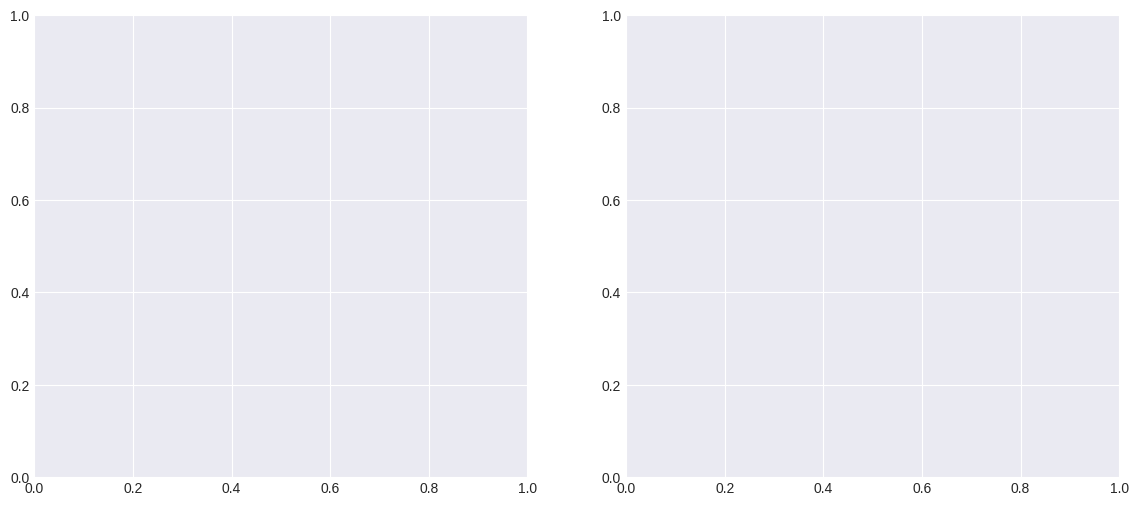

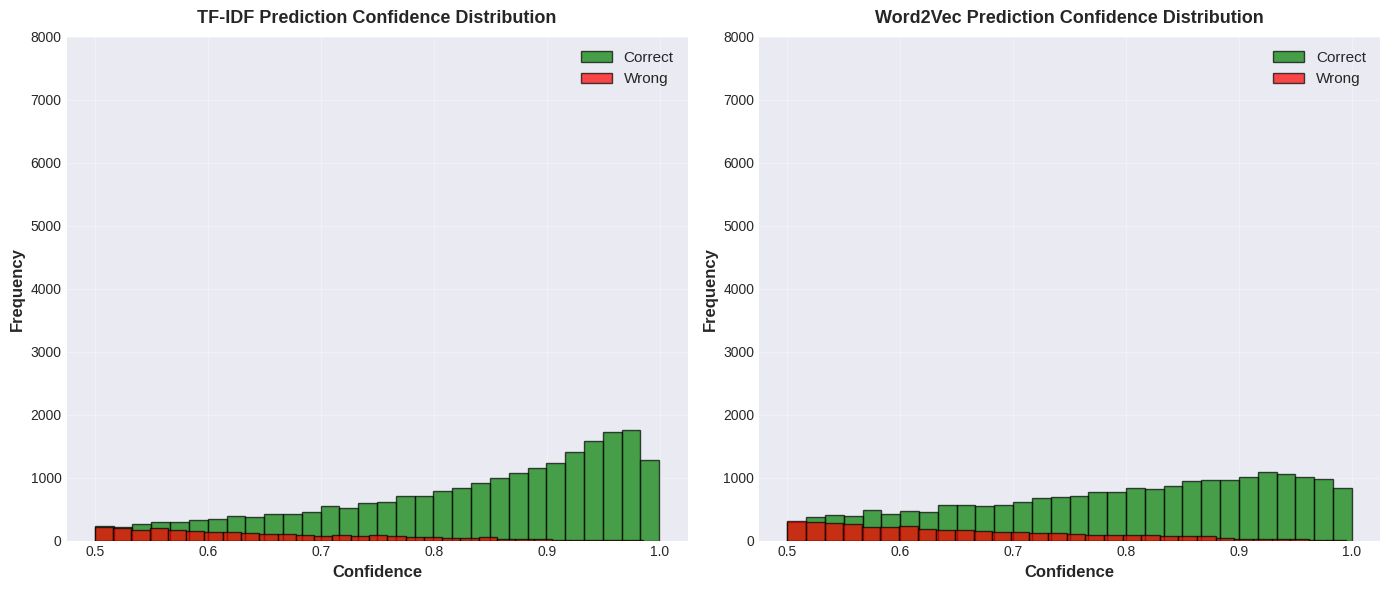

In [ ]:
# Performing Confidence Analysis

print("\nAnalyzing prediction confidence...")

# Average confidence for correct vs incorrect predictions
tfidf_correct_conf = np.mean([tfidf_proba[i] if y_test[i]==1 else 1-tfidf_proba[i]
                               for i in range(len(y_test)) if tfidf_correct[i]==1])
tfidf_wrong_conf = np.mean([tfidf_proba[i] if tfidf_pred[i]==1 else 1-tfidf_proba[i]
                             for i in range(len(y_test)) if tfidf_correct[i]==0])

w2v_correct_conf = np.mean([w2v_proba[i] if y_test[i]==1 else 1-w2v_proba[i]
                             for i in range(len(y_test)) if w2v_correct[i]==1])
w2v_wrong_conf = np.mean([w2v_proba[i] if w2v_pred[i]==1 else 1-w2v_proba[i]
                           for i in range(len(y_test)) if w2v_correct[i]==0])

print("CONFIDENCE ANALYSIS")
print(f"\nTF-IDF:")
print(f"  Avg confidence when correct: {tfidf_correct_conf:.3f}")
print(f"  Avg confidence when wrong:   {tfidf_wrong_conf:.3f}")
print(f"  Confidence gap:              {tfidf_correct_conf - tfidf_wrong_conf:.3f}")

print(f"\nWord2Vec:")
print(f"  Avg confidence when correct: {w2v_correct_conf:.3f}")
print(f"  Avg confidence when wrong:   {w2v_wrong_conf:.3f}")
print(f"  Confidence gap:              {w2v_correct_conf - w2v_wrong_conf:.3f}")

# Visualization: Confidence distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# TF-IDF confidence
tfidf_conf_correct = [tfidf_proba[i] if y_test[i]==1 else 1-tfidf_proba[i]
                      for i in range(len(y_test)) if tfidf_correct[i]==1]
tfidf_conf_wrong = [tfidf_proba[i] if tfidf_pred[i]==1 else 1-tfidf_proba[i]
                    for i in range(len(y_test)) if tfidf_correct[i]==0]

# Visualization: Confidence distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# TF-IDF confidence
tfidf_conf_correct = [tfidf_proba[i] if y_test[i]==1 else 1-tfidf_proba[i]
                      for i in range(len(y_test)) if tfidf_correct[i]==1]
tfidf_conf_wrong = [tfidf_proba[i] if tfidf_pred[i]==1 else 1-tfidf_proba[i]
                    for i in range(len(y_test)) if tfidf_correct[i]==0]

ax1.hist(tfidf_conf_correct, bins=30, alpha=0.7, label='Correct', color='green', edgecolor='black')
ax1.hist(tfidf_conf_wrong, bins=30, alpha=0.7, label='Wrong', color='red', edgecolor='black')
ax1.set_xlabel('Confidence', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('TF-IDF Prediction Confidence Distribution', fontsize=13, fontweight='bold', pad=10)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_ylim([0, 8000])  # Set consistent y-axis scale

# Word2Vec confidence
w2v_conf_correct = [w2v_proba[i] if y_test[i]==1 else 1-w2v_proba[i]
                    for i in range(len(y_test)) if w2v_correct[i]==1]
w2v_conf_wrong = [w2v_proba[i] if w2v_pred[i]==1 else 1-w2v_proba[i]
                  for i in range(len(y_test)) if w2v_correct[i]==0]

ax2.hist(w2v_conf_correct, bins=30, alpha=0.7, label='Correct', color='green', edgecolor='black')
ax2.hist(w2v_conf_wrong, bins=30, alpha=0.7, label='Wrong', color='red', edgecolor='black')
ax2.set_xlabel('Confidence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Word2Vec Prediction Confidence Distribution', fontsize=13, fontweight='bold', pad=10)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 8000])  # Set consistent y-axis scale

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

**Key Insights**

KEY INSIGHTS FROM ERROR ANALYSIS

1. OVERALL PATTERN:
   
   TF-IDF outperforms Word2Vec overall
   
   TF-IDF correctly classifies 2128 more reviews than Word2Vec

2. CONFIDENCE:
   
   TF-IDF shows better confidence calibration (larger gap: 0.188)
   
   TF-IDF is more certain when it's correct

3. CHALLENGING CASES:
   
   1682 reviews (6.73%) are misclassified by BOTH models
   
   These likely contain sarcasm, mixed sentiment, or ambiguous language

4. WHY TF-IDF WINS (Key Reasons):
   
   Domain-specific feature learning: TF-IDF learns from movie reviews directly
   
   Discriminative features: Identifies rare words that strongly indicate sentiment
   
   Bigram capture: Can capture phrases like 'not good' as single features
   
   Word2Vec averaging dilutes strong sentiment signals

5. WHERE WORD2VEC COULD HELP:
   
   Handling synonyms and paraphrasing
   
   Dealing with out-of-vocabulary words
   
   Smaller training datasets (transfer learning advantage)
   
   Cross-domain sentiment analysis

In [ ]:
# Saving Error Analysis Results

error_analysis_results = {
    'prediction_patterns': {
        'both_correct': int(len(both_correct_idx)),
        'tfidf_only_correct': int(len(tfidf_correct_w2v_wrong)),
        'w2v_only_correct': int(len(w2v_correct_tfidf_wrong)),
        'both_wrong': int(len(both_wrong))
    },
    'confidence_analysis': {
        'tfidf_correct_conf': float(tfidf_correct_conf),
        'tfidf_wrong_conf': float(tfidf_wrong_conf),
        'w2v_correct_conf': float(w2v_correct_conf),
        'w2v_wrong_conf': float(w2v_wrong_conf)
    },
    'example_indices': {
        'tfidf_wins': tfidf_correct_w2v_wrong[:10].tolist(),
        'w2v_wins': w2v_correct_tfidf_wrong[:10].tolist(),
        'both_fail': both_wrong[:10].tolist()
    }
}

with open('error_analysis_results.pkl', 'wb') as f:
    pickle.dump(error_analysis_results, f)

print("Error analysis results saved to 'error_analysis_results.pkl'")

Error analysis results saved to 'error_analysis_results.pkl'


In [ ]:
print("FINAL SUMMARY")

print(f"\nBest Overall Model: TF-IDF + Logistic Regression")
print(f"Best Accuracy: {tfidf_best_acc*100:.2f}%")
print(f"Hypothesis Result: REJECTED (TF-IDF outperforms Word2Vec)")
print(f"\nKey Finding: Domain-specific features (TF-IDF) outperform general transfer")
print(f"learning (Word2Vec) for sentiment analysis when sufficient training data exists.")

FINAL SUMMARY

Best Overall Model: TF-IDF + Logistic Regression
Best Accuracy: 89.70%
Hypothesis Result: REJECTED (TF-IDF outperforms Word2Vec)

Key Finding: Domain-specific features (TF-IDF) outperform general transfer
learning (Word2Vec) for sentiment analysis when sufficient training data exists.
